Необходимо построить предсказательную модель, которая будет выявлять, кто из покупателей совершит покупки в последующие 30 дней. В распоряжении три дата-сета с данными по покупкам клиентов. 
Первый - магазин одежды, второй - маркетплейс, третий - магазин подарков.

#### Необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#модели
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import Pool
from catboost.utils import get_roc_curve, get_confusion_matrix
from catboost import CatBoostClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Обзор Данных

In [2]:
df1 = pd.read_csv('apparel-purchases.csv')
df2 = pd.read_csv('marketplace-purchases.csv')
df3 = pd.read_csv('gifts-purchases.csv')

- У нас ограниченный набор данных. Доступны: id покупателя, id рекламной рассылки, дата покупки, цена и количество товара.
- Стоит так же дополнительно сказать, что каждый товар разнесён на отдельную позицию, поэтому нужно будет объеденить заказы.

In [3]:
display(df1, df2, df3)

,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
1,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
2,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
3,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
4,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
...,...,...,...,...,...,...
133099,1515915625909375164,1,2399.0,2022-12-31,1515915625490956133-9110-63ae8ee3e5e7f,bulk_message
133100,1515915625909375164,1,2399.0,2022-12-31,1515915625490956133-9110-63ae8ee3e5e7f,bulk_message
133101,1515915625909375164,1,1699.0,2022-12-31,1515915625490956133-9110-63ae8ee3e5e7f,bulk_message
133102,1515915625909375164,1,1699.0,2022-12-31,1515915625490956133-9110-63ae8ee3e5e7f,bulk_message


,client_id,quantity,price,message_id,created_at,date
0,1515915625440944408,1,6298.0,1515915625440944408-1752-6450b79616277,2023-05-02,2023-05-02 08:49:57
1,1515915625440992498,1,7318.0,1515915625440992498-1818-646b35d089c98,2023-05-22,2023-05-22 13:52:13
2,1515915625441026424,1,65798.0,1515915625441026424-1802-64634e24a2cb9,2023-05-17,2023-05-17 11:21:04
3,1515915625441118180,1,5598.0,1515915625441118180-1820-646c9444ebf39,2023-05-23,2023-05-23 19:02:53
4,1515915625441124500,1,77998.0,1515915625441124500-1825-646ed5cf4d5ed,2023-05-25,2023-05-25 07:46:52
...,...,...,...,...,...,...
48177,1515915625575803144,1,29998.0,1515915625520976171-1747-644b87709eac8,2023-04-29,2023-04-29 11:19:29
48178,1515915625575803144,1,29998.0,1515915625520976171-1747-644b87709eac8,2023-04-29,2023-04-29 11:19:29
48179,1515915625575808251,1,25998.0,1515915625542646315-1748-644b600b9435d,2023-04-29,2023-04-29 11:46:30
48180,1515915625575809442,1,15998.0,1515915625518408482-1747-644b876fe63e6,2023-04-29,2023-04-29 08:48:11


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625803894158,1,8943.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
1,1515915625803894158,1,46369.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
2,1515915625803894158,1,4666.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
3,1515915625803894158,1,11963.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
4,1515915625803894158,1,13107.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
...,...,...,...,...,...,...
806,1515915625870025628,1,39992.0,2022-11-28,1515915625867543212-8163-6383352a4f29f,bulk_message
807,1515915625873498326,1,3035.0,2022-11-23,1515915625873498326-8044-637ccf9a38a17,bulk_message
808,1515915625873498326,1,3035.0,2022-11-23,1515915625873498326-8044-637ccf9a38a17,bulk_message
809,1515915625878133961,1,3442.0,2022-11-26,1515915625866862784-8170-6380c36047d7f,bulk_message


In [4]:
display(df1.info(), df2.info(), df3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133104 entries, 0 to 133103
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   client_id       133104 non-null  int64  
 1   quantity        133104 non-null  int64  
 2   price           133104 non-null  float64
 3   date            133104 non-null  object 
 4   message_id      133104 non-null  object 
 5   recommended_by  133104 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 6.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   client_id   48182 non-null  int64  
 1   quantity    48182 non-null  int64  
 2   price       48182 non-null  float64
 3   message_id  48182 non-null  object 
 4   created_at  48182 non-null  object 
 5   date        48182 non-null  object 
dtypes: float64(1), int6

None

None

None

- Посмотрим, пересекаются ли клиенты и "message_id" в таблицах.

In [5]:
a = df1.client_id.unique()
b = df2.client_id.unique()
c = df3.client_id.unique()
np.intersect1d(a,b,True), np.intersect1d(a,c,True), np.intersect1d(c,b,True)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [6]:
a = df1.message_id.unique()
b = df2.message_id.unique()
c = df3.message_id.unique()
np.intersect1d(a,b,True), np.intersect1d(a,c,True), np.intersect1d(c,b,True)

(array([], dtype=object), array([], dtype=object), array([], dtype=object))

- Пересечений нет. Получается "рекламные акции" и клиенты везде собственные.

In [7]:
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])
df2['created_at'] = pd.to_datetime(df2['created_at'])
df3['date'] = pd.to_datetime(df3['date'])

In [8]:
display(df1.describe(), df2.describe(), df3.describe())

,client_id,quantity,price,date
count,1.331040e+05,133104.000000,133104.000000,133104
mean,1.515916e+18,1.004312,1110.433067,2023-04-04 04:27:23.562928128
min,1.515916e+18,1.000000,1.000000,2022-10-26 00:00:00
25%,1.515916e+18,1.000000,280.000000,2022-12-22 00:00:00
50%,1.515916e+18,1.000000,799.000000,2023-04-19 00:00:00
75%,1.515916e+18,1.000000,1499.000000,2023-06-16 00:00:00
max,1.515916e+18,30.000000,63499.000000,2023-10-26 00:00:00
std,1.422078e+08,0.149315,1257.080854,NaN


,client_id,quantity,price,created_at,date
count,4.818200e+04,48182.000000,4.818200e+04,48182,48182
mean,1.515916e+18,1.017413,2.791895e+04,2023-04-29 09:56:34.080776960,2023-04-29 21:02:39.993960448
min,1.515916e+18,1.000000,0.000000e+00,2022-10-26 00:00:00,2022-10-26 08:35:46
25%,1.515916e+18,1.000000,1.204250e+03,2023-02-03 00:00:00,2023-02-03 19:49:36
50%,1.515916e+18,1.000000,9.998000e+03,2023-04-18 00:00:00,2023-04-18 05:33:04.500000
75%,1.515916e+18,1.000000,3.599800e+04,2023-08-12 00:00:00,2023-08-12 05:08:25.500000
max,1.515916e+18,50.000000,1.299998e+06,2023-10-26 00:00:00,2023-10-26 13:34:11
std,3.173388e+07,0.540592,4.492274e+04,NaN,NaN


,client_id,quantity,price,date
count,8.110000e+02,811.000000,811.000000,811
mean,1.515916e+18,1.003699,14468.795314,2023-04-27 23:45:47.718865664
min,1.515916e+18,1.000000,656.000000,2022-10-26 00:00:00
25%,1.515916e+18,1.000000,3878.000000,2023-01-31 00:00:00
50%,1.515916e+18,1.000000,7533.000000,2023-05-22 00:00:00
75%,1.515916e+18,1.000000,17938.000000,2023-07-12 00:00:00
max,1.515916e+18,2.000000,173586.000000,2023-10-24 00:00:00
std,6.255407e+07,0.060745,17774.341837,NaN


- Судя по датам, все датасеты за один и тот же период времени.
- Начало 2022-10-26 08:35:46, конец 2023-10-26 13:34:11
- Среднее количество штук в покупке - в пределах погрешности от единицы. Очень странно.
- Цены катострафически варьируются. В магазине одежды есть товары за рубль, в интернет магазине есть бесплатные товары.
- Максимальная стоимость товара в магащине одежны - 63.5к, в интернет площадке - 1300к, в магазине подарков - 173.5к.
- Максимальное количество данных с магащине одежды - 133 тысячи, на маркетплейсе - 48 тысяч, в магазине с сувенирами всего 811 записей.
- Временной период одинаковый для всех магазинов - с 26 октября 2022 по 26 октября 2023.


In [9]:
df1.date.value_counts(), df2.created_at.value_counts(), df2.date.dt.hour.value_counts(), df3.date.value_counts()

(date
 2022-11-11    5270
 2023-06-10    3836
 2023-04-28    3473
 2022-11-15    2937
 2022-12-22    2631
               ... 
 2023-02-26       6
 2023-01-16       5
 2023-08-06       4
 2023-01-09       3
 2023-01-29       2
 Name: count, Length: 366, dtype: int64,
 created_at
 2022-11-11    848
 2023-02-25    564
 2022-12-23    557
 2022-11-25    472
 2023-03-03    449
              ... 
 2023-01-02      4
 2023-01-29      4
 2022-10-30      4
 2023-07-09      2
 2022-10-26      1
 Name: count, Length: 365, dtype: int64,
 date
 11    4632
 10    4303
 12    4199
 9     3625
 13    3566
 6     3138
 8     3137
 7     3071
 14    2962
 5     2722
 15    2377
 4     1907
 16    1706
 17    1461
 18    1316
 3     1087
 19     728
 20     568
 2      512
 21     415
 22     272
 1      226
 23     154
 0       98
 Name: count, dtype: int64,
 date
 2023-05-22    46
 2023-10-11    26
 2022-11-08    23
 2023-07-01    18
 2023-01-31    17
               ..
 2023-05-15     1
 2023-04-16     1

- Посмотрим, сколько клиентов, совершивших покупки 11-11, покупали в другие дни. Если никто не покупал - отбросим эти значения. 

In [10]:
a = df1[df1['date'] == '2022-11-11'].client_id.unique()
b = df1[df1['date'] != '2022-11-11'].client_id.unique()

len(np.intersect1d(a,b,True)), len(df1[df1['date'] == '2022-11-11'].client_id.unique())

(247, 1141)

- 247 из 1141 покупателей на 11-11 покупали и в другие дни в магазине одежды.

In [11]:
a = df2[df2['created_at'] == '2022-11-11'].client_id.unique()
b = df2[df2['created_at'] != '2022-11-11'].client_id.unique()

len(np.intersect1d(a,b,True)), len(df2[df2['created_at'] == '2022-11-11'].client_id.unique())

(153, 400)

- 153 из 400 покупателей на 11-11 покупали и в другие дни на маркетплейсе.

- У двух из трёх магаинов самая большая активность на распродажу 11-11. 
- Видим, что достаточно большое количество клиентов участвует в распродажах.
- Посмотрим распределение по месяцам и дням месяца.

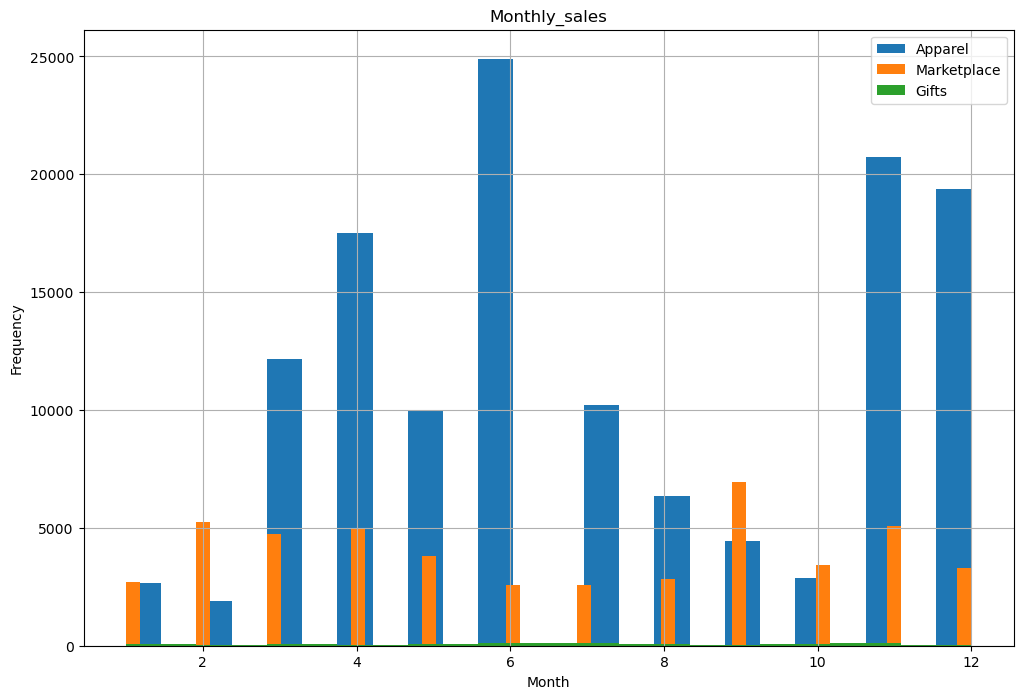

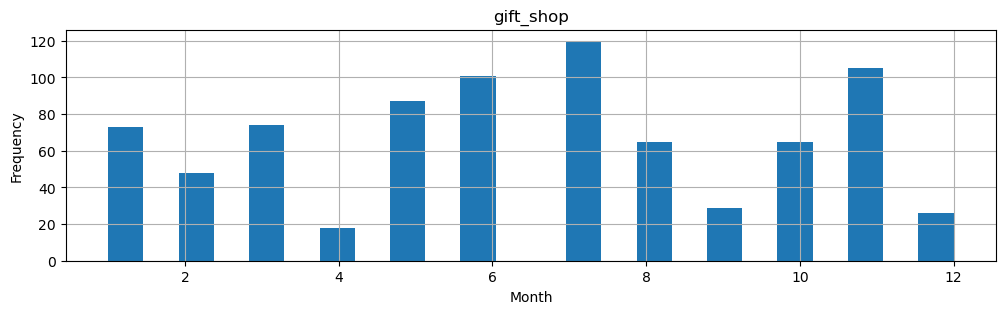

In [12]:
ax = df1.date.dt.month.hist(bins = 24, figsize=(12,8))
df2.date.dt.month.hist(bins = 60)
df3.date.dt.month.hist(bins = 12)
ax.set_xlabel('Month')
ax.set_ylabel('Frequency')
ax.set_title('Monthly_sales')
ax.legend(['Apparel','Marketplace','Gifts'])
plt.show()
None
bx = df3.date.dt.month.hist(bins = 24, figsize=(12,3))
bx.set_xlabel('Month')
bx.set_ylabel('Frequency')
bx.set_title('gift_shop')
plt.show()

- У магазинов очень разная сезонность.

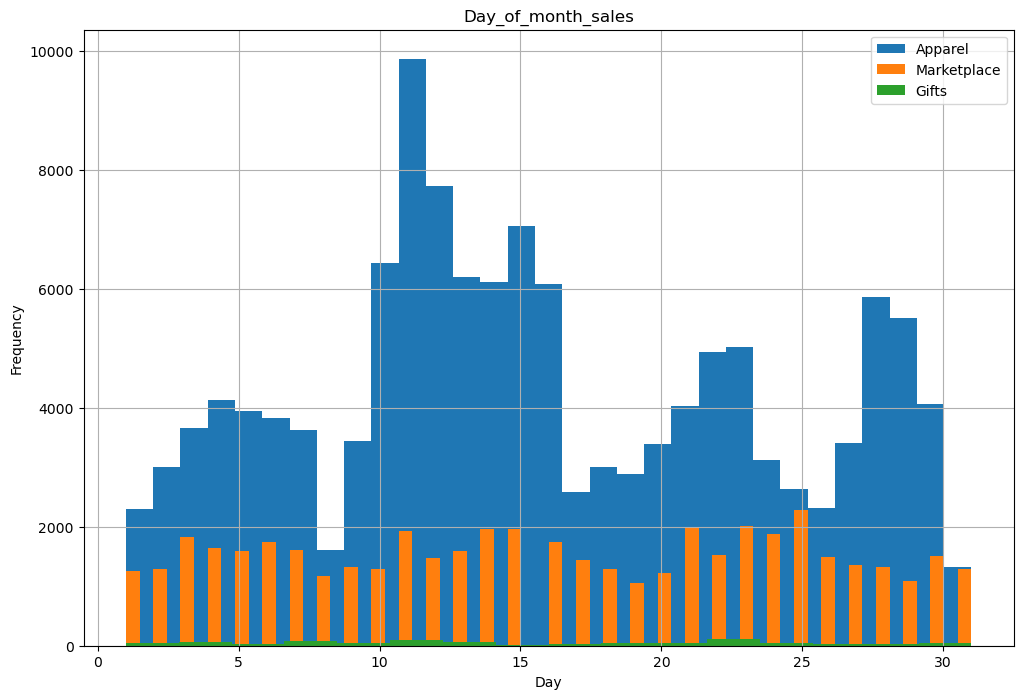

In [13]:
ax = df1.date.dt.day.hist(bins = 31, figsize=(12,8))
df2.date.dt.day.hist(bins = 62)
df3.date.dt.day.hist(bins = 16)
ax.set_xlabel('Day')
ax.set_ylabel('Frequency')
ax.set_title('Day_of_month_sales')
ax.legend(['Apparel','Marketplace','Gifts'])
None

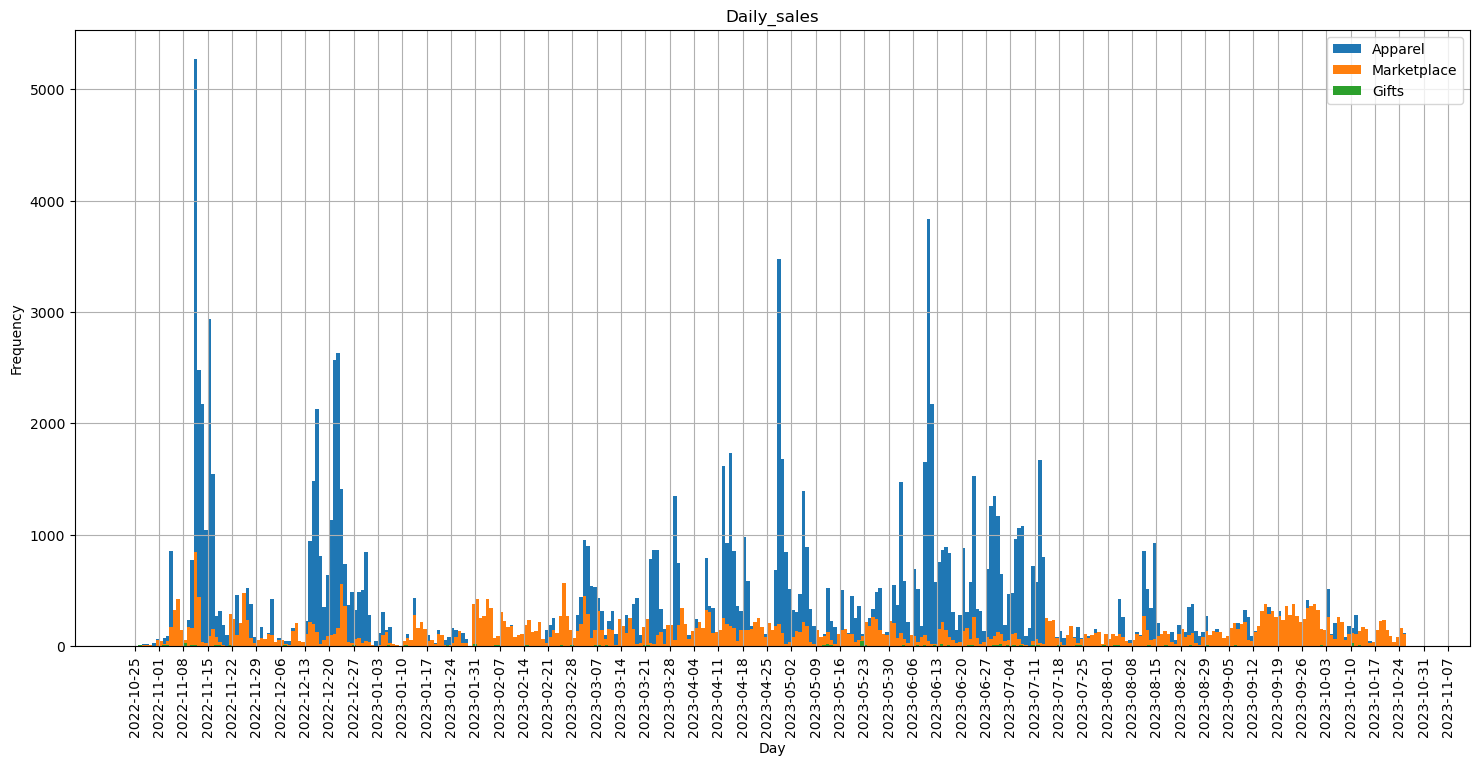

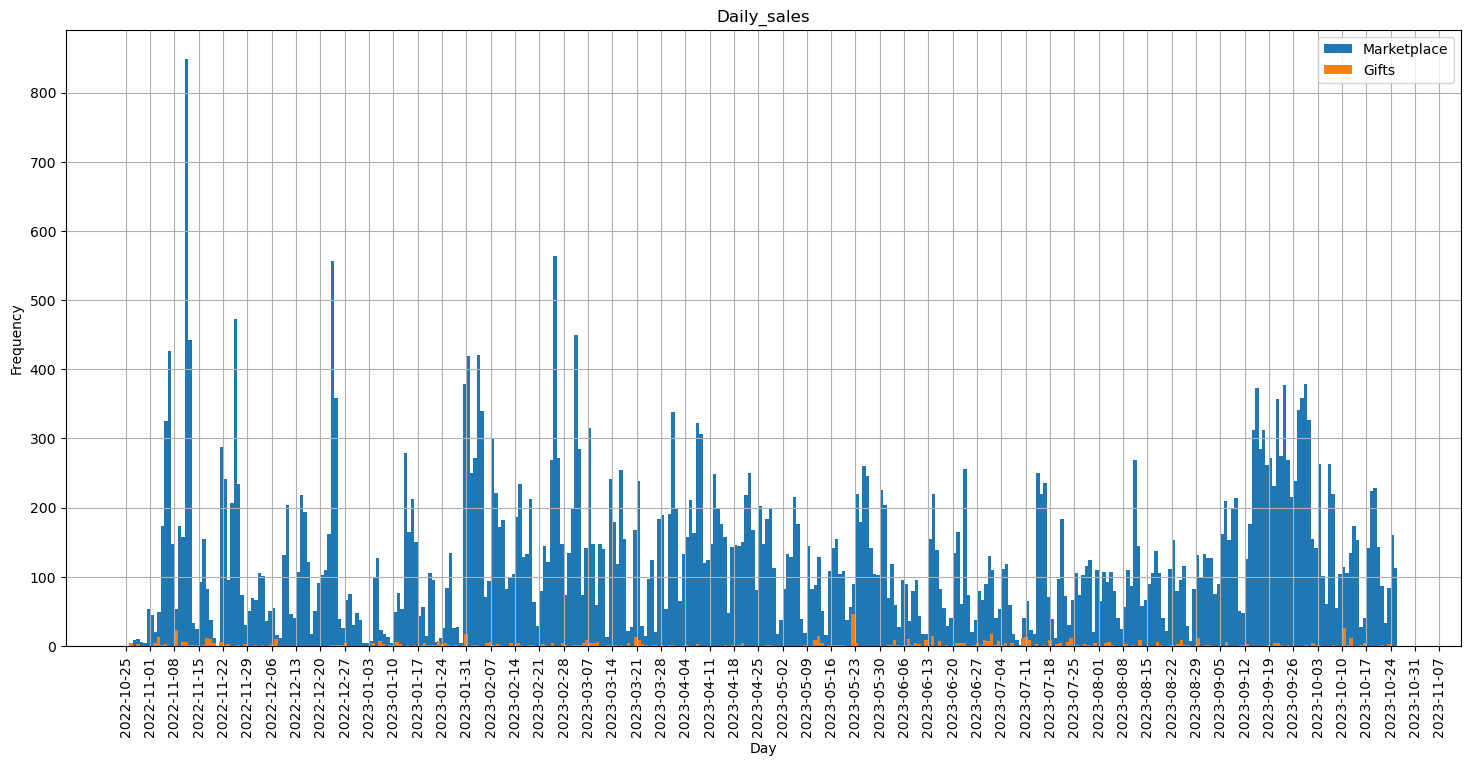

In [14]:
ax = df1.date.hist(bins = 365, figsize=(18,8), xrot= 90)
df2.created_at.hist(bins = 365)
df3.date.hist(bins = 365)
ax.set_xlabel('Day')
ax.set_ylabel('Frequency')
ax.set_title('Daily_sales')
ax.legend(['Apparel','Marketplace','Gifts'])
plt.xticks(np.arange(19290,19670,7))
plt.show()
None
bx = df2.created_at.hist(bins = 365, figsize=(18,8), xrot= 90)
df3.date.hist(bins = 365)
bx.set_xlabel('Day')
bx.set_ylabel('Frequency')
bx.set_title('Daily_sales')
bx.legend(['Marketplace','Gifts'])
plt.xticks(np.arange(19290,19670,7))
plt.show()
None

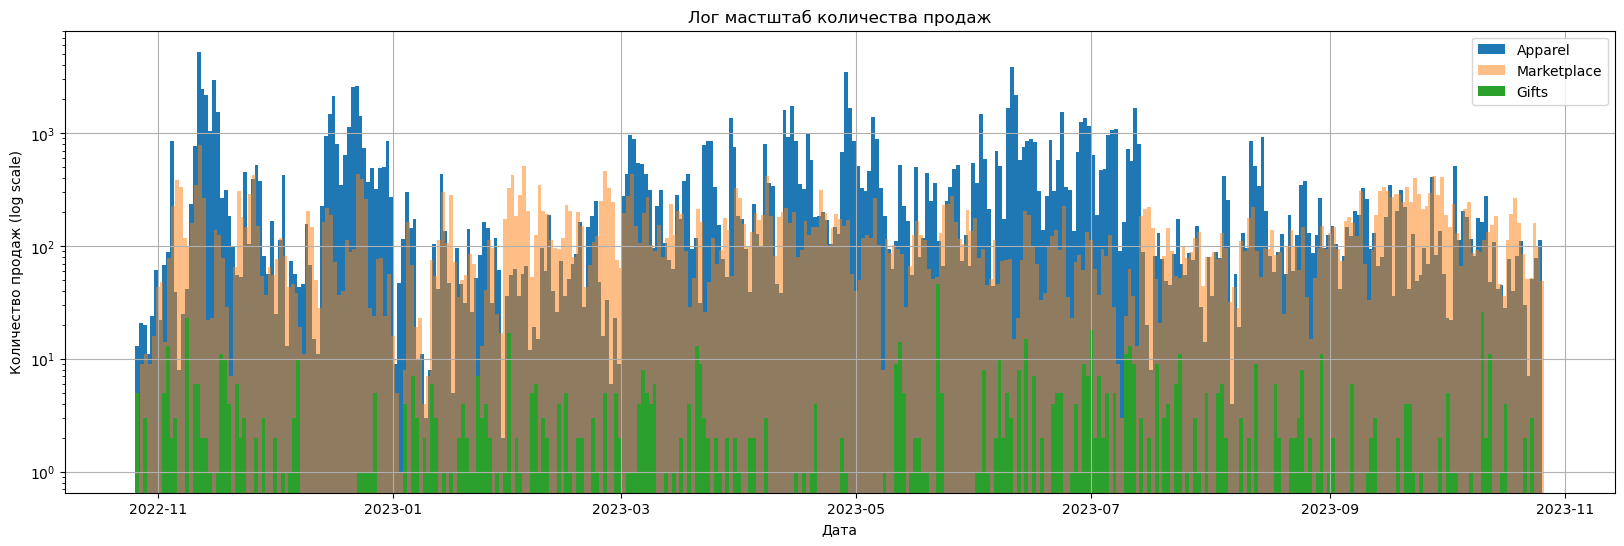

In [15]:
plt.figure(figsize=(20,6))
ax = df1.date.hist(bins =365)
df2.date.hist(bins =365, alpha = 0.5)
df3.date.hist(bins =365)
plt.yscale(value = 'log')
plt.legend(['df1','df2','df3'])
ax.set_xlabel('Дата')
ax.set_ylabel('Количество продаж (log scale)')
ax.set_title('Лог мастштаб количества продаж')
ax.legend(['Apparel','Marketplace','Gifts'])
#plt.xticks(np.arange(19290,19670,7))
None

- Распродажа 11-11 сильно испортила картину продаж по числам. 
- Видим, что сезонность спроса в разных магазинах кардинально меняется.
- Рассмотрим гистограмму цен на проданные товары.

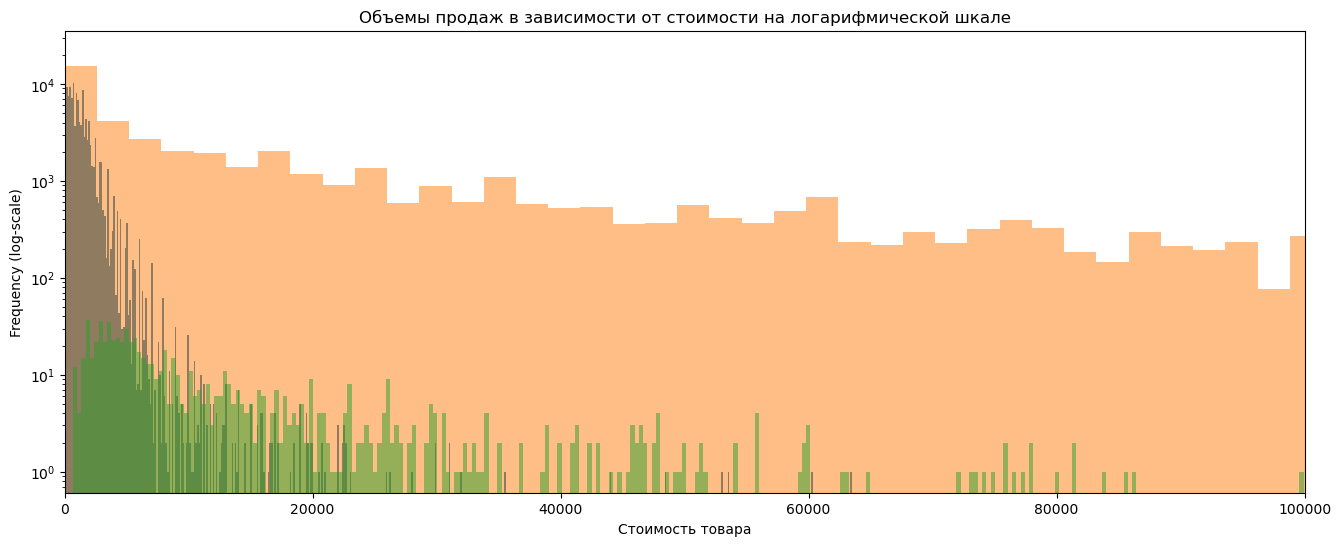

In [16]:
plt.figure(figsize=(16,6))
plt.hist(df1.price, bins = 500)
plt.hist(df2.price, bins = 500, alpha = 0.5)
plt.hist(df3.price, bins = 500, alpha = 0.5)
plt.yscale(value = 'log')
plt.xlim((0,100000))
plt.xlabel('Стоимость товара')
plt.ylabel('Frequency (log-scale)')
plt.title('Объемы продаж в зависимости от стоимости на логарифмической шкале')
plt.show()
None

- Нормируем данные на максимальную стоимость, чтобы увидеть распределение продаж.

In [17]:
def resize(df, column):
    return (df[column]/df[column].max())

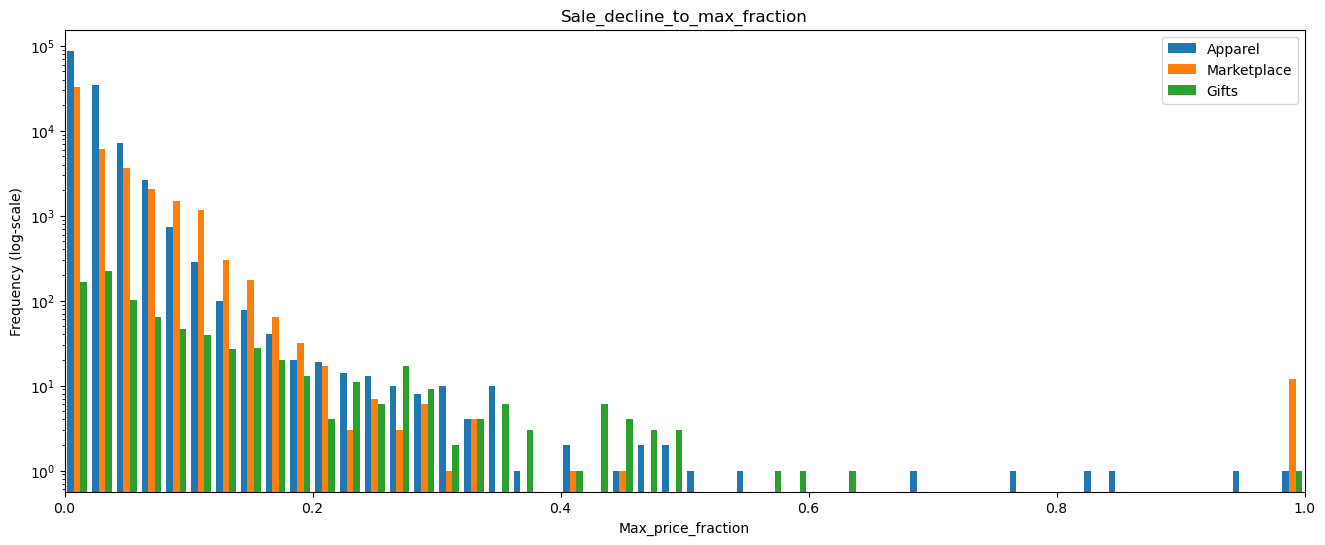

In [18]:
plt.figure(figsize=(16,6))
plt.hist([resize(df1, 'price'),resize(df2, 'price'),resize(df3, 'price')], 
         bins = 50)
plt.yscale(value = 'log')
plt.xlim(0,1)
plt.legend(['Apparel','Marketplace','Gifts'])
plt.xlabel('Max_price_fraction')
plt.ylabel('Frequency (log-scale)')
plt.title('Sale_decline_to_max_fraction')
plt.show()
None

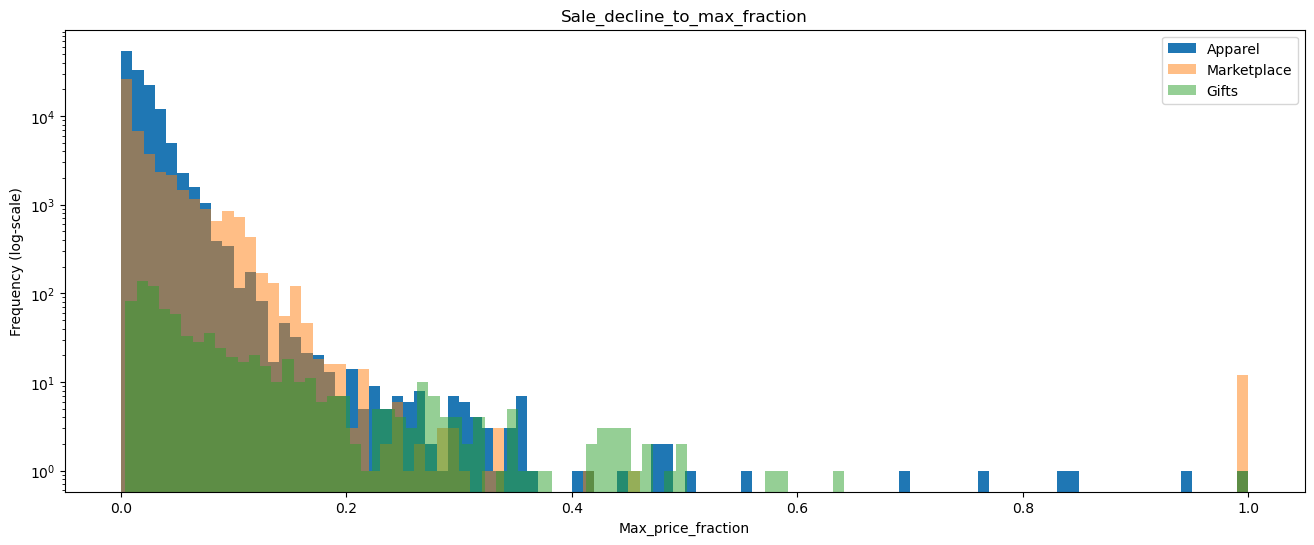

In [19]:
plt.figure(figsize=(16,6))
plt.hist(resize(df1, 'price'), bins = 100)
plt.hist(resize(df2, 'price'), bins = 100, alpha = 0.5)
plt.hist(resize(df3, 'price'), bins = 100, alpha = 0.5)
plt.yscale(value = 'log')
#plt.xlim((0,100000))
plt.legend(['Apparel','Marketplace','Gifts'])
plt.xlabel('Max_price_fraction')
plt.ylabel('Frequency (log-scale)')
plt.title('Sale_decline_to_max_fraction')
plt.show()
None

- При нормировке на максимальную цену товара видно, что динамика заказов схожа. Вероятно, что чем более разнообразнен доступный ассортимент, тем выше будет средний чек покупки.
- Есть вероятность, что если добавить в магазин какое-то количество очень дорогих товаров, которые будет видеть пользователь, то средний чек покупки увеличится.

In [20]:
df1.price.value_counts(), df2.price.value_counts(), df3.price.value_counts()

(price
 999.0     4414
 699.0     4154
 1499.0    3055
 1399.0    2921
 1999.0    2908
           ... 
 3704.0       1
 4522.0       1
 3400.0       1
 3938.0       1
 2787.0       1
 Name: count, Length: 3335, dtype: int64,
 price
 2.0        5569
 17998.0     723
 11998.0     577
 19998.0     572
 7998.0      535
            ... 
 2731.0        1
 4361.0        1
 5765.0        1
 1235.0        1
 16558.0       1
 Name: count, Length: 4991, dtype: int64,
 price
 3627.0     12
 4990.0      9
 669.0       8
 19990.0     8
 7990.0      7
            ..
 1103.0      1
 4972.0      1
 3647.0      1
 2960.0      1
 2695.0      1
 Name: count, Length: 598, dtype: int64)

- Посмотрим, какой процент покупателей совершают более одной покупки. Создадим цикл, который считает процент пользователей, у которых более чем Х (переменная) покупок.
- Получился очень длинный сортировочный запрос. Он считает, сколько разных дат в списке покупок у конкретного пользователя.
- Вот какую таблицу он создаёт:

In [21]:
df1.groupby(by=['client_id', 'date']).agg({'date':['count']}).sort_values(by = [('date','count')], ascending= False).groupby(by = 'client_id').agg({('date', 'count'): 'count'}).sort_values(by = [('date','count')], ascending= False)

,date
,count
client_id,
1515915625853312319,28
1515915625860624470,15
1515915625579040539,12
1515915625500232103,12
1515915625468102493,12
...,...
1515915625501152799,1
1515915625501152619,1


- По всеё видимости, количество людей, которые возвращаются в магазин крайне мало, поэтому ещё посмотрим, сколько людей покупают больше одной единицы товара.
- Сортировочная строка создает вот такую таблицу (он считает количество купленных товаров всего):

In [22]:
df1.groupby(by='client_id').agg({'date':['count']}).sort_values(by = [('date','count')], ascending= False)

,date
,count
client_id,
1515915625853312319,275
1515915625624308268,218
1515915625607113301,210
1515915625500232103,113
1515915625490352441,111
...,...
1515915625502606379,1
1515915625815836494,1


In [23]:
loyalty_df1 = []
loyalty_df2 = []
loyalty_df3 = []
for x in range(0,25):
    loyalty_df1.append((df1.groupby(by='client_id').agg({'date':['count']}).sort_values(by = [('date','count')], ascending= False) > x).sum().item()/ len(df1.client_id.unique()) * 100)
    loyalty_df2.append((df2.groupby(by='client_id').agg({'created_at':['count']}).sort_values(by = [('created_at','count')], ascending= False) > x).sum().item()/ len(df2.client_id.unique())* 100)
    loyalty_df3.append((df3.groupby(by='client_id').agg({'date':['count']}).sort_values(by = [('date','count')], ascending= False) > x).sum().item()/ len(df3.client_id.unique())* 100)



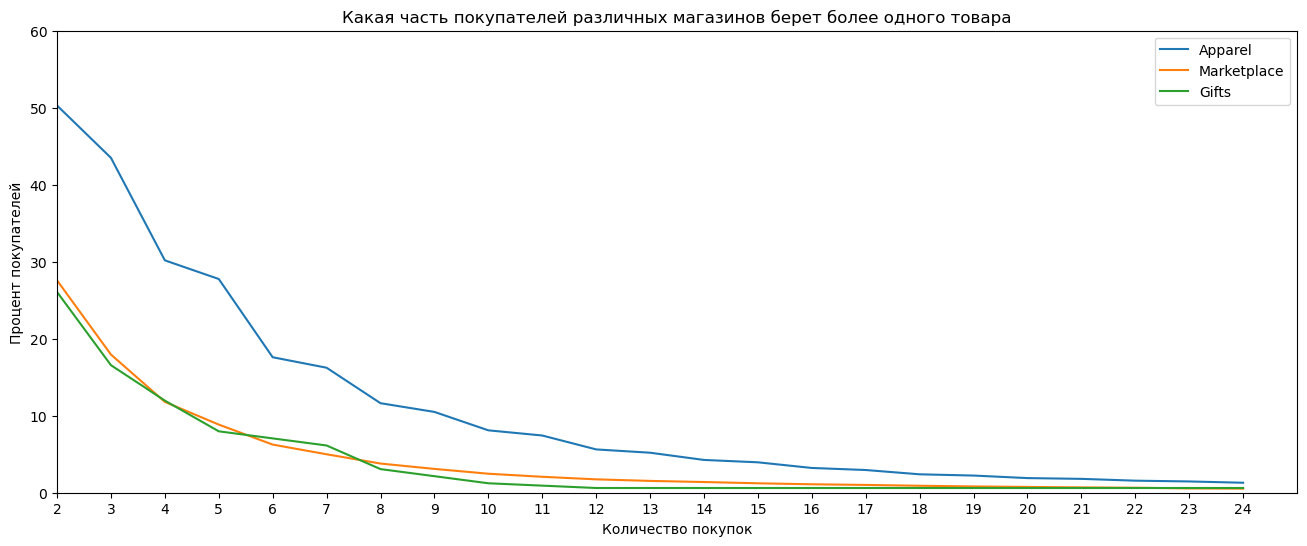

In [24]:
plt.figure(figsize=(16,6))
plt.plot(loyalty_df1)
plt.plot(loyalty_df2)
plt.plot(loyalty_df3)
plt.legend(['Apparel','Marketplace','Gifts'])
plt.xlabel('Количество покупок')
plt.ylabel('Процент покупателей')
plt.title('Какая часть покупателей различных магазинов берет более одного товара')
plt.xlim(2,25)
plt.ylim(0,60)
plt.xticks(np.arange(2,25))
plt.show()


In [25]:
loyalty_df1 = []
loyalty_df2 = []
loyalty_df3 = []
for x in range(0,25):
    loyalty_df1.append((df1.groupby(by=['client_id', 'date']).agg({'date':['count']}).sort_values(by = [('date','count')], ascending= False).groupby(by = 'client_id').agg({('date', 'count'): 'count'}).sort_values(by = [('date','count')], ascending= False) > x).sum().item()/ len(df1.client_id.unique()) * 100)
    loyalty_df2.append((df2.groupby(by=['client_id', 'created_at']).agg({'created_at':['count']}).sort_values(by = [('created_at','count')], ascending= False).groupby(by = 'client_id').agg({('created_at', 'count'): 'count'}).sort_values(by = [('created_at','count')], ascending= False) > x).sum().item()/ len(df2.client_id.unique())* 100)
    loyalty_df3.append((df3.groupby(by=['client_id', 'date']).agg({'date':['count']}).sort_values(by = [('date','count')], ascending= False).groupby(by = 'client_id').agg({('date', 'count'): 'count'}).sort_values(by = [('date','count')], ascending= False) > x).sum().item()/ len(df3.client_id.unique())* 100)



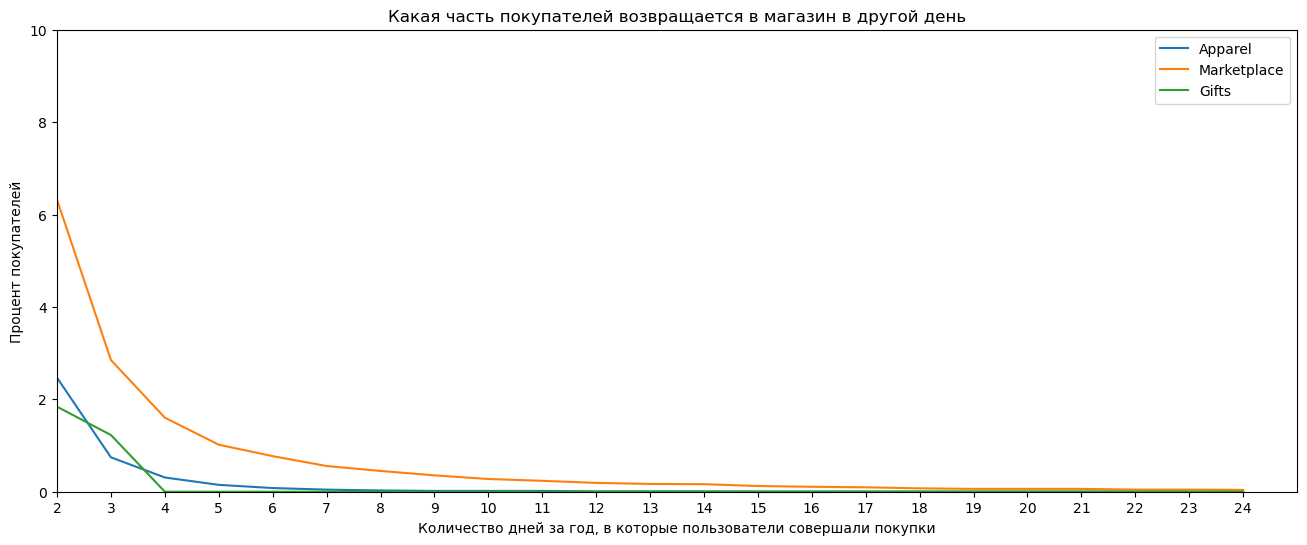

In [26]:
plt.figure(figsize=(16,6))
plt.plot(loyalty_df1)
plt.plot(loyalty_df2)
plt.plot(loyalty_df3)
plt.legend(['Apparel','Marketplace','Gifts'])
plt.xlabel('Количество дней за год, в которые пользователи совершали покупки')
plt.ylabel('Процент покупателей')
plt.title('Какая часть покупателей возвращается в магазин в другой день')
plt.xlim(2,25)
plt.ylim(0,10)
plt.xticks(np.arange(2,25))
plt.show()


- Интересно, что кривые количества покупок покупателей маркетплейса и магазина подарков практически идентична, а у магазина одежны примерно в два раза выше.
- Однако, в маркетплейс возвращаются в 2-3 раща чаще. Тем не менее, даже там менее 2% покупателей покупают больше 3 дней в году.
- Очевидно, что если создавать единую модель, то нужно в неё передвать коррекционный коэффициент для суммы покупки и лояльности покупателя. Как это сделать? Отличный вопрос, спасибо за вопрос.

In [27]:
df1.quantity.value_counts(), df2.quantity.value_counts(), df3.quantity.value_counts()

(quantity
 1     132743
 2        286
 3         52
 4          7
 6          5
 15         3
 5          2
 9          2
 20         1
 30         1
 18         1
 8          1
 Name: count, dtype: int64,
 quantity
 1     47915
 2       148
 3        55
 4        18
 5        11
 10       10
 7         7
 6         6
 50        4
 8         3
 27        1
 9         1
 23        1
 20        1
 30        1
 Name: count, dtype: int64,
 quantity
 1    808
 2      3
 Name: count, dtype: int64)

Крайне редко покупают более одной единицы товара. Есть шанс, что покупающие по 3 и более одинаковых товаров редко возвращаются в магазин.
Проверим, пересекаются ли уникальные пользователи, которые покупали что-то в большем, чем один, количестве

In [28]:
_temp = df1.groupby(by='client_id').agg({'date':['count']}).sort_values(by = [('date','count')], ascending= False)
_temp = _temp[_temp[('date'),('count')] >1]
b = _temp.index.unique()
a = df1.query('quantity > 1').client_id.unique()
print(len(np.intersect1d(a,b,True)))


198


In [29]:
_temp = df2.groupby(by='client_id').agg({'date':['count']}).sort_values(by = [('date','count')], ascending= False)
_temp = _temp[_temp[('date'),('count')] >1]
b = _temp.index.unique()
a = df2.query('quantity > 1').client_id.unique()
print(len(np.intersect1d(a,b,True)))

120


In [30]:
_temp = df3.groupby(by='client_id').agg({'date':['count']}).sort_values(by = [('date','count')], ascending= False)
_temp = _temp[_temp[('date'),('count')] >1]
b = _temp.index.unique()
a = df3.query('quantity > 1').client_id.unique()
print(len(np.intersect1d(a,b,True)))

3


### Выводы по обзору данных.

- Каждый товар вынесен в отдельную покупку, необходимо пересобрать датасет.
- У магазинов различная сезонность и различная лояльность аудитории.
- При этом возможно нормировать цену товаров на максимальную, тогда тренд количества продаж похож.

## Подготовка Данных

- Целью работы является предсказание покупки на следующие 30 дней. Соответственно, мы соберем данные по датасетам за 11 месяцев, и те из клиентов, которые совершат покупку в последний месяц будут целевой группой.
- Таким образом признаки необходимо собирать по данным до 2023-09-26.

In [31]:
a = df1.query('date <= "2023-09-26"').client_id.unique()
b = df1.query('date > "2023-09-26"').client_id.unique()
target_df1 = np.intersect1d(a,b,True)
print(f'Таргет: {len(target_df1)}, уникальных покупателей до октября {len(a)}, уникальных покупателей в октябре {len(b)}')

Таргет: 158, уникальных покупателей до октября 28236, уникальных покупателей в октябре 813


In [32]:
a = df2.query('date <= "2023-09-26"').client_id.unique()
b = df2.query('date > "2023-09-26"').client_id.unique()
target_df2 = np.intersect1d(a,b,True)
print(f'Таргет: {len(target_df2)}, уникальных покупателей до октября {len(a)}, уникальных покупателей в октябре {len(b)}')

Таргет: 507, уникальных покупателей до октября 16084, уникальных покупателей в октябре 2210


In [33]:
a = df3.query('date <= "2023-09-26"').client_id.unique()
b = df3.query('date > "2023-09-26"').client_id.unique()
target_df3 = np.intersect1d(a,b,True)
print(f'Таргет: {len(target_df3)}, уникальных покупателей до октября {len(a)}, уникальных покупателей в октябре {len(b)}')

Таргет: 3, уникальных покупателей до октября 308, уникальных покупателей в октябре 21


- Мы видим, что у нас очень низкое количество таргетов.
- Мы можем искуственно увеличить количество таргетов, если добавим туда сагрегированные данные до сентября, сделов целевым признаком покупку в сентябре.

In [34]:
a = df1.query('date <= "2023-08-26"').client_id.unique()
b = df1.query('"2023-09-26" >= date > "2023-08-26"').client_id.unique()
target_df1_plus = np.intersect1d(a,b,True)
print(f'Дополнительный таргет: {len(target_df1_plus)}, уникальных покупателей до сентября {len(a)}, уникальных покупателей в сентябре {len(b)}')

Дополнительный таргет: 181, уникальных покупателей до сентября 27286, уникальных покупателей в сентябре 1131


In [35]:
a = df2.query('date <= "2023-08-26"').client_id.unique()
b = df2.query('"2023-09-26" >= date > "2023-08-26"').client_id.unique()
target_df2_plus = np.intersect1d(a,b,True)
print(f'Дополнительный таргет: {len(target_df2_plus)}, уникальных покупателей до сентября {len(a)}, уникальных покупателей в сентябре {len(b)}')

Дополнительный таргет: 479, уникальных покупателей до сентября 14001, уникальных покупателей в сентябре 2562


In [36]:
a = df3.query('date <= "2023-08-26"').client_id.unique()
b = df3.query('"2023-09-26" >= date > "2023-08-26"').client_id.unique()
target_df3_plus = np.intersect1d(a,b,True)
print(f'Дополнительный таргет: {len(target_df3_plus)}, уникальных покупателей до сентября {len(a)}, уникальных покупателей в сентябре {len(b)}')

Дополнительный таргет: 2, уникальных покупателей до сентября 288, уникальных покупателей в сентябре 22


In [37]:
data_1 = df1.query('date <= "2023-09-26"')
data_2 = df2.query('date <= "2023-09-26"')
data_3 = df3.query('date <= "2023-09-26"')
data_1_plus = df1.query('date <= "2023-08-26"')
data_2_plus = df2.query('date <= "2023-08-26"')
data_3_plus = df3.query('date <= "2023-08-26"')


In [38]:
data_1['total'] = data_1.quantity*data_1.price
data_2['total'] = data_2.quantity*data_2.price
data_3['total'] = data_3.quantity*data_3.price
data_1_plus['total'] = data_1_plus.quantity*data_1_plus.price
data_2_plus['total'] = data_2_plus.quantity*data_2_plus.price
data_3_plus['total'] = data_3_plus.quantity*data_3_plus.price

/tmp/ipykernel_4462/1059436104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['total'] = data_1.quantity*data_1.price
/tmp/ipykernel_4462/1059436104.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['total'] = data_2.quantity*data_2.price
/tmp/ipykernel_4462/1059436104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

- Сформируем список покупок. Будем исходить из гипотезы, что человек чаще раза в день не покупает, поэтому будем агрегировать по дате.
- Мы, конечно же, понимаем, что гипотеза не правильная. В маркетплейсе есть указание времени, которое разнится в течении дня. Тем не менее, эта разница не должна быть принципиальной. 
- Один датасет сделаем подробно, остальные сжато.

In [39]:
_data2 = data_2.groupby(by=['client_id', 'created_at'], as_index= False).agg({'quantity': sum, 'total': sum, 'price' : [min, max, 'mean', list],
                                                                       'created_at': ['first', lambda x: min(x.dt.month), lambda x: min(x.dt.day), lambda x: min(x.dt.day_of_week)]
                                                                    # [(lambda list: list[-1:] - list[-2:-1])]
                                                        })
_data2.columns = ['client_id','quantity_purchase','total_price','min_price','max_price','mean_price','purchase_price_list','date','month','day','weekday']
_data2

,client_id,quantity_purchase,total_price,min_price,max_price,mean_price,purchase_price_list,date,month,day,weekday
0,1515915625440099873,1,31998.0,31998.0,31998.0,31998.000000,[31998.0],2023-07-16,7,16,6
1,1515915625440099873,1,1218.0,1218.0,1218.0,1218.000000,[1218.0],2023-08-09,8,9,2
2,1515915625440939402,1,75998.0,75998.0,75998.0,75998.000000,[75998.0],2023-01-30,1,30,0
3,1515915625440944408,1,882.0,882.0,882.0,882.000000,[882.0],2023-03-01,3,1,2
4,1515915625440944408,1,6298.0,6298.0,6298.0,6298.000000,[6298.0],2023-05-02,5,2,1
...,...,...,...,...,...,...,...,...,...,...,...
21396,1515915625586553545,6,438988.0,35998.0,154998.0,110331.333333,"[35998.0, 139998.0, 154998.0]",2023-09-14,9,14,3
21397,1515915625586579290,2,38996.0,12998.0,25998.0,19498.000000,"[12998.0, 25998.0]",2023-06-01,6,1,3
21398,1515915625586588051,5,177982.0,4.0,69998.0,35993.333333,"[69998.0, 37978.0, 4.0]",2023-06-21,6,21,2
21399,1515915625586604047,3,78794.0,1798.0,64998.0,26264.666667,"[11998.0, 1798.0, 64998.0]",2023-08-22,8,22,1


- Из списков мы возьмем самые частые значения.

In [40]:
_data2 = _data2.groupby(by=['client_id'], as_index= False).agg({'quantity_purchase': [sum, 'count'], 'total_price': [sum, min], 'min_price' : [min, 'mean'],  'max_price' : [max, 'mean'], 'mean_price' : 'mean',  
                                                                       'purchase_price_list': list, 'date': list, 
                                                                       'month' : [list, lambda list: np.argmax(np.bincount(list))],
                                                                       'day' : [list, lambda list: np.argmax(np.bincount(list))],
                                                                       'weekday' : [list, lambda list: np.argmax(np.bincount(list))] 
                                                                })
_data2.columns = ['client_id','quantity_purchased','count_purchase','total_spent','min_order','min_price', 'mean_min_price', 'max_price', 'mean_max_price','mean_order','purchase_price_list',
                   'date_list','month_list','most_freq_month','day_list','most_freq_day','weekday_list','most_freq_weekday']
_data2

,client_id,quantity_purchased,count_purchase,total_spent,min_order,min_price,mean_min_price,max_price,mean_max_price,mean_order,purchase_price_list,date_list,month_list,most_freq_month,day_list,most_freq_day,weekday_list,most_freq_weekday
0,1515915625440099873,2,2,33216.0,1218.0,1218.0,16608.000000,31998.0,16608.000000,16608.000000,"[[31998.0], [1218.0]]","[2023-07-16 00:00:00, 2023-08-09 00:00:00]","[7, 8]",7,"[16, 9]",9,"[6, 2]",2
1,1515915625440939402,1,1,75998.0,75998.0,75998.0,75998.000000,75998.0,75998.000000,75998.000000,[[75998.0]],[2023-01-30 00:00:00],[1],1,[30],30,[0],0
2,1515915625440944408,3,3,81178.0,882.0,882.0,27059.333333,73998.0,27059.333333,27059.333333,"[[882.0], [6298.0], [73998.0]]","[2023-03-01 00:00:00, 2023-05-02 00:00:00, 202...","[3, 5, 6]",3,"[1, 2, 21]",1,"[2, 1, 2]",2
3,1515915625440947454,4,2,4486.0,202.0,2.0,144.000000,3998.0,2099.000000,1121.500000,"[[2.0, 200.0], [286.0, 3998.0]]","[2022-11-06 00:00:00, 2022-12-24 00:00:00]","[11, 12]",11,"[6, 24]",6,"[6, 5]",5
4,1515915625440952940,1,1,479.0,479.0,479.0,479.000000,479.0,479.000000,479.000000,[[479.0]],[2022-11-11 00:00:00],[11],11,[11],11,[4],4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16079,1515915625586553545,6,1,438988.0,438988.0,35998.0,35998.000000,154998.0,154998.000000,110331.333333,"[[35998.0, 139998.0, 154998.0]]",[2023-09-14 00:00:00],[9],9,[14],14,[3],3
16080,1515915625586579290,2,1,38996.0,38996.0,12998.0,12998.000000,25998.0,25998.000000,19498.000000,"[[12998.0, 25998.0]]",[2023-06-01 00:00:00],[6],6,[1],1,[3],3
16081,1515915625586588051,5,1,177982.0,177982.0,4.0,4.000000,69998.0,69998.000000,35993.333333,"[[69998.0, 37978.0, 4.0]]",[2023-06-21 00:00:00],[6],6,[21],21,[2],2
16082,1515915625586604047,3,1,78794.0,78794.0,1798.0,1798.000000,64998.0,64998.000000,26264.666667,"[[11998.0, 1798.0, 64998.0]]",[2023-08-22 00:00:00],[8],8,[22],22,[1],1


In [41]:
_data2['target'] = 0
for x in _data2.index:
    if _data2.loc[x, 'client_id'] in target_df2:
        _data2.loc[x, 'target'] = 1
_data2.query('target == 1')

,client_id,quantity_purchased,count_purchase,total_spent,min_order,min_price,mean_min_price,max_price,mean_max_price,mean_order,purchase_price_list,date_list,month_list,most_freq_month,day_list,most_freq_day,weekday_list,most_freq_weekday,target
22,1515915625440995965,6,3,441004.0,9.0,9.0,58802.333333,88199.0,58802.333333,58802.333333,"[[88199.0, 88199.0], [88199.0, 88199.0, 88199....","[2023-03-03 00:00:00, 2023-03-04 00:00:00, 202...","[3, 3, 9]",3,"[3, 4, 6]",3,"[4, 5, 2]",2,1
23,1515915625440996406,25,9,318908.0,4198.0,2.0,9161.666667,79196.0,19958.000000,14309.500000,"[[3098.0, 4398.0, 6498.0, 3998.0, 2398.0], [41...","[2022-11-04 00:00:00, 2022-11-05 00:00:00, 202...","[11, 11, 11, 2, 3, 8, 9, 9, 9]",9,"[4, 5, 9, 9, 31, 12, 20, 21, 23]",9,"[4, 5, 2, 3, 4, 5, 2, 3, 5]",5,1
27,1515915625441007350,1,1,35998.0,35998.0,35998.0,35998.000000,35998.0,35998.000000,35998.000000,[[35998.0]],[2023-04-13 00:00:00],[4],4,[13],13,[3],3,1
42,1515915625441084418,1,1,4553.0,4553.0,4553.0,4553.000000,4553.0,4553.000000,4553.000000,[[4553.0]],[2023-09-09 00:00:00],[9],9,[9],9,[5],5,1
46,1515915625441096040,3,2,149994.0,39996.0,19998.0,64998.000000,109998.0,64998.000000,64998.000000,"[[19998.0, 19998.0], [109998.0]]","[2023-07-21 00:00:00, 2023-08-10 00:00:00]","[7, 8]",7,"[21, 10]",10,"[4, 3]",3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15868,1515915625584827550,10,3,464982.0,35996.0,2.0,29999.333333,71998.0,53998.000000,46998.095238,"[[55998.0, 56998.0, 30998.0, 71998.0, 70998.0,...","[2023-09-12 00:00:00, 2023-09-17 00:00:00, 202...","[9, 9, 9]",9,"[12, 17, 23]",12,"[1, 6, 5]",1,1
15906,1515915625585356178,3,2,10396.0,2398.0,2.0,4000.000000,7998.0,5197.000000,4598.500000,"[[2.0, 2396.0], [7998.0]]","[2023-09-14 00:00:00, 2023-09-15 00:00:00]","[9, 9]",9,"[14, 15]",14,"[3, 4]",3,1
15949,1515915625585572620,1,1,133998.0,133998.0,133998.0,133998.000000,133998.0,133998.000000,133998.000000,[[133998.0]],[2023-09-19 00:00:00],[9],9,[19],19,[1],1,1
15983,1515915625585873152,1,1,598.0,598.0,598.0,598.000000,598.0,598.000000,598.000000,[[598.0]],[2023-09-24 00:00:00],[9],9,[24],24,[6],6,1


In [42]:
_data2_plus = data_2_plus.groupby(by=['client_id', 'created_at'], as_index= False).agg({'quantity': sum, 'total': sum, 'price' : [min, max, 'mean', list],
                                                                       'created_at': ['first', lambda x: min(x.dt.month), lambda x: min(x.dt.day), lambda x: min(x.dt.day_of_week)]
                                                                    # [(lambda list: list[-1:] - list[-2:-1])]
                                                        })
_data2_plus.columns = ['client_id','quantity_purchase','total_price','min_price','max_price','mean_price','purchase_price_list','date','month','day','weekday']
_data2_plus = _data2_plus.groupby(by=['client_id'], as_index= False).agg({'quantity_purchase': [sum, 'count'], 'total_price': [sum, min], 'min_price' : [min, 'mean'],  'max_price' : [max, 'mean'], 'mean_price' : 'mean',  
                                                                       'purchase_price_list': list, 'date': list, 
                                                                       'month' : [list, lambda list: np.argmax(np.bincount(list))],
                                                                       'day' : [list, lambda list: np.argmax(np.bincount(list))],
                                                                       'weekday' : [list, lambda list: np.argmax(np.bincount(list))] 
                                                                })
_data2_plus.columns = ['client_id','quantity_purchased','count_purchase','total_spent','min_order','min_price', 'mean_min_price', 'max_price', 'mean_max_price','mean_order','purchase_price_list',
                   'date_list','month_list','most_freq_month','day_list','most_freq_day','weekday_list','most_freq_weekday']
_data2_plus['target'] = 0
for x in _data2_plus.index:
    if _data2_plus.loc[x, 'client_id'] in target_df2_plus:
        _data2_plus.loc[x, 'target'] = 1
_data2_plus = _data2_plus.query('target == 1')
_data2_plus

,client_id,quantity_purchased,count_purchase,total_spent,min_order,min_price,mean_min_price,max_price,mean_max_price,mean_order,purchase_price_list,date_list,month_list,most_freq_month,day_list,most_freq_day,weekday_list,most_freq_weekday,target
21,1515915625440995965,5,2,440995.0,176398.0,88199.0,88199.000000,88199.0,88199.0,88199.000000,"[[88199.0, 88199.0], [88199.0, 88199.0, 88199.0]]","[2023-03-03 00:00:00, 2023-03-04 00:00:00]","[3, 3]",3,"[3, 4]",3,"[4, 5]",4,1
22,1515915625440996406,16,6,248219.0,4198.0,2.0,9309.833333,79196.0,24454.5,16856.611111,"[[3098.0, 4398.0, 6498.0, 3998.0, 2398.0], [41...","[2022-11-04 00:00:00, 2022-11-05 00:00:00, 202...","[11, 11, 11, 2, 3, 8]",11,"[4, 5, 9, 9, 31, 12]",9,"[4, 5, 2, 3, 4, 5]",4,1
31,1515915625441039680,2,1,30000.0,30000.0,2.0,2.000000,29998.0,29998.0,15000.000000,"[[2.0, 29998.0]]",[2023-08-17 00:00:00],[8],8,[17],17,[3],3,1
35,1515915625441064223,2,1,98497.0,98497.0,47499.0,47499.000000,50998.0,50998.0,49248.500000,"[[47499.0, 50998.0]]",[2023-04-12 00:00:00],[4],4,[12],12,[2],2,1
51,1515915625441149463,1,1,28798.0,28798.0,28798.0,28798.000000,28798.0,28798.0,28798.000000,[[28798.0]],[2023-02-01 00:00:00],[2],2,[1],1,[2],2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13809,1515915625581038906,2,1,73796.0,73796.0,32398.0,32398.000000,41398.0,41398.0,36898.000000,"[[32398.0, 41398.0]]",[2023-08-17 00:00:00],[8],8,[17],17,[3],3,1
13896,1515915625582176225,5,1,140396.0,140396.0,2.0,2.000000,70196.0,70196.0,28079.200000,"[[2.0, 70196.0, 2.0, 2.0, 70194.0]]",[2023-08-11 00:00:00],[8],8,[11],11,[4],4,1
13906,1515915625582370531,1,1,1918.0,1918.0,1918.0,1918.000000,1918.0,1918.0,1918.000000,[[1918.0]],[2023-08-08 00:00:00],[8],8,[8],8,[1],1,1
13943,1515915625583079944,3,2,110194.0,5198.0,5198.0,27598.000000,54998.0,30098.0,28848.000000,"[[5198.0], [49998.0, 54998.0]]","[2023-08-11 00:00:00, 2023-08-12 00:00:00]","[8, 8]",8,"[11, 12]",11,"[4, 5]",4,1


In [43]:
df2_agg = pd.concat([_data2, _data2_plus], ignore_index=True)
df2_agg

,client_id,quantity_purchased,count_purchase,total_spent,min_order,min_price,mean_min_price,max_price,mean_max_price,mean_order,purchase_price_list,date_list,month_list,most_freq_month,day_list,most_freq_day,weekday_list,most_freq_weekday,target
0,1515915625440099873,2,2,33216.0,1218.0,1218.0,16608.000000,31998.0,16608.000000,16608.000000,"[[31998.0], [1218.0]]","[2023-07-16 00:00:00, 2023-08-09 00:00:00]","[7, 8]",7,"[16, 9]",9,"[6, 2]",2,0
1,1515915625440939402,1,1,75998.0,75998.0,75998.0,75998.000000,75998.0,75998.000000,75998.000000,[[75998.0]],[2023-01-30 00:00:00],[1],1,[30],30,[0],0,0
2,1515915625440944408,3,3,81178.0,882.0,882.0,27059.333333,73998.0,27059.333333,27059.333333,"[[882.0], [6298.0], [73998.0]]","[2023-03-01 00:00:00, 2023-05-02 00:00:00, 202...","[3, 5, 6]",3,"[1, 2, 21]",1,"[2, 1, 2]",2,0
3,1515915625440947454,4,2,4486.0,202.0,2.0,144.000000,3998.0,2099.000000,1121.500000,"[[2.0, 200.0], [286.0, 3998.0]]","[2022-11-06 00:00:00, 2022-12-24 00:00:00]","[11, 12]",11,"[6, 24]",6,"[6, 5]",5,0
4,1515915625440952940,1,1,479.0,479.0,479.0,479.000000,479.0,479.000000,479.000000,[[479.0]],[2022-11-11 00:00:00],[11],11,[11],11,[4],4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16558,1515915625581038906,2,1,73796.0,73796.0,32398.0,32398.000000,41398.0,41398.000000,36898.000000,"[[32398.0, 41398.0]]",[2023-08-17 00:00:00],[8],8,[17],17,[3],3,1
16559,1515915625582176225,5,1,140396.0,140396.0,2.0,2.000000,70196.0,70196.000000,28079.200000,"[[2.0, 70196.0, 2.0, 2.0, 70194.0]]",[2023-08-11 00:00:00],[8],8,[11],11,[4],4,1
16560,1515915625582370531,1,1,1918.0,1918.0,1918.0,1918.000000,1918.0,1918.000000,1918.000000,[[1918.0]],[2023-08-08 00:00:00],[8],8,[8],8,[1],1,1
16561,1515915625583079944,3,2,110194.0,5198.0,5198.0,27598.000000,54998.0,30098.000000,28848.000000,"[[5198.0], [49998.0, 54998.0]]","[2023-08-11 00:00:00, 2023-08-12 00:00:00]","[8, 8]",8,"[11, 12]",11,"[4, 5]",4,1


- Ранее мы показывали, что все цены очень сильно варьируются, в зависимости от максимальной цены на маркетплейсе. Поэтому цены мы нормируем на максимальную, а так же добавим идентификатор магазина.

In [44]:
money_columns = ['total_spent','min_order','min_price','mean_min_price','max_price','mean_max_price','mean_order']

In [45]:
for x in money_columns:
    df2_agg[x] = df2_agg[x]/df2.price.max()
df2_agg

,client_id,quantity_purchased,count_purchase,total_spent,min_order,min_price,mean_min_price,max_price,mean_max_price,mean_order,purchase_price_list,date_list,month_list,most_freq_month,day_list,most_freq_day,weekday_list,most_freq_weekday,target
0,1515915625440099873,2,2,0.025551,0.000937,0.000937,0.012775,0.024614,0.012775,0.012775,"[[31998.0], [1218.0]]","[2023-07-16 00:00:00, 2023-08-09 00:00:00]","[7, 8]",7,"[16, 9]",9,"[6, 2]",2,0
1,1515915625440939402,1,1,0.058460,0.058460,0.058460,0.058460,0.058460,0.058460,0.058460,[[75998.0]],[2023-01-30 00:00:00],[1],1,[30],30,[0],0,0
2,1515915625440944408,3,3,0.062445,0.000678,0.000678,0.020815,0.056922,0.020815,0.020815,"[[882.0], [6298.0], [73998.0]]","[2023-03-01 00:00:00, 2023-05-02 00:00:00, 202...","[3, 5, 6]",3,"[1, 2, 21]",1,"[2, 1, 2]",2,0
3,1515915625440947454,4,2,0.003451,0.000155,0.000002,0.000111,0.003075,0.001615,0.000863,"[[2.0, 200.0], [286.0, 3998.0]]","[2022-11-06 00:00:00, 2022-12-24 00:00:00]","[11, 12]",11,"[6, 24]",6,"[6, 5]",5,0
4,1515915625440952940,1,1,0.000368,0.000368,0.000368,0.000368,0.000368,0.000368,0.000368,[[479.0]],[2022-11-11 00:00:00],[11],11,[11],11,[4],4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16558,1515915625581038906,2,1,0.056766,0.056766,0.024922,0.024922,0.031845,0.031845,0.028383,"[[32398.0, 41398.0]]",[2023-08-17 00:00:00],[8],8,[17],17,[3],3,1
16559,1515915625582176225,5,1,0.107997,0.107997,0.000002,0.000002,0.053997,0.053997,0.021599,"[[2.0, 70196.0, 2.0, 2.0, 70194.0]]",[2023-08-11 00:00:00],[8],8,[11],11,[4],4,1
16560,1515915625582370531,1,1,0.001475,0.001475,0.001475,0.001475,0.001475,0.001475,0.001475,[[1918.0]],[2023-08-08 00:00:00],[8],8,[8],8,[1],1,1
16561,1515915625583079944,3,2,0.084765,0.003998,0.003998,0.021229,0.042306,0.023152,0.022191,"[[5198.0], [49998.0, 54998.0]]","[2023-08-11 00:00:00, 2023-08-12 00:00:00]","[8, 8]",8,"[11, 12]",11,"[4, 5]",4,1


In [46]:
df2_agg['store'] = 2 
df2_agg

,client_id,quantity_purchased,count_purchase,total_spent,min_order,min_price,mean_min_price,max_price,mean_max_price,mean_order,purchase_price_list,date_list,month_list,most_freq_month,day_list,most_freq_day,weekday_list,most_freq_weekday,target,store
0,1515915625440099873,2,2,0.025551,0.000937,0.000937,0.012775,0.024614,0.012775,0.012775,"[[31998.0], [1218.0]]","[2023-07-16 00:00:00, 2023-08-09 00:00:00]","[7, 8]",7,"[16, 9]",9,"[6, 2]",2,0,2
1,1515915625440939402,1,1,0.058460,0.058460,0.058460,0.058460,0.058460,0.058460,0.058460,[[75998.0]],[2023-01-30 00:00:00],[1],1,[30],30,[0],0,0,2
2,1515915625440944408,3,3,0.062445,0.000678,0.000678,0.020815,0.056922,0.020815,0.020815,"[[882.0], [6298.0], [73998.0]]","[2023-03-01 00:00:00, 2023-05-02 00:00:00, 202...","[3, 5, 6]",3,"[1, 2, 21]",1,"[2, 1, 2]",2,0,2
3,1515915625440947454,4,2,0.003451,0.000155,0.000002,0.000111,0.003075,0.001615,0.000863,"[[2.0, 200.0], [286.0, 3998.0]]","[2022-11-06 00:00:00, 2022-12-24 00:00:00]","[11, 12]",11,"[6, 24]",6,"[6, 5]",5,0,2
4,1515915625440952940,1,1,0.000368,0.000368,0.000368,0.000368,0.000368,0.000368,0.000368,[[479.0]],[2022-11-11 00:00:00],[11],11,[11],11,[4],4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16558,1515915625581038906,2,1,0.056766,0.056766,0.024922,0.024922,0.031845,0.031845,0.028383,"[[32398.0, 41398.0]]",[2023-08-17 00:00:00],[8],8,[17],17,[3],3,1,2
16559,1515915625582176225,5,1,0.107997,0.107997,0.000002,0.000002,0.053997,0.053997,0.021599,"[[2.0, 70196.0, 2.0, 2.0, 70194.0]]",[2023-08-11 00:00:00],[8],8,[11],11,[4],4,1,2
16560,1515915625582370531,1,1,0.001475,0.001475,0.001475,0.001475,0.001475,0.001475,0.001475,[[1918.0]],[2023-08-08 00:00:00],[8],8,[8],8,[1],1,1,2
16561,1515915625583079944,3,2,0.084765,0.003998,0.003998,0.021229,0.042306,0.023152,0.022191,"[[5198.0], [49998.0, 54998.0]]","[2023-08-11 00:00:00, 2023-08-12 00:00:00]","[8, 8]",8,"[11, 12]",11,"[4, 5]",4,1,2


- Набор признаков готов. Повторим всё тоже самое для других данных.

In [47]:
#объединяем по покупкам
_data1 = data_1.groupby(by=['client_id', 'date'], as_index= False).agg({'quantity': sum, 'total': sum, 'price' : [min, max, 'mean', list],
                                                                       'date': ['first', lambda x: min(x.dt.month), lambda x: min(x.dt.day), lambda x: min(x.dt.day_of_week)]
                                                        })
_data1.columns = ['client_id','quantity_purchase','total_price','min_price','max_price','mean_price','purchase_price_list','date','month','day','weekday']

#объединяем по клиентам

_data1 = _data1.groupby(by=['client_id'], as_index= False).agg({'quantity_purchase': [sum, 'count'], 'total_price': [sum, min], 'min_price' : [min, 'mean'],  'max_price' : [max, 'mean'], 'mean_price' : 'mean',  
                                                                       'purchase_price_list': list, 'date': list, 
                                                                       'month' : [list, lambda list: np.argmax(np.bincount(list))],
                                                                       'day' : [list, lambda list: np.argmax(np.bincount(list))],
                                                                       'weekday' : [list, lambda list: np.argmax(np.bincount(list))] 
                                                                })
_data1.columns = ['client_id','quantity_purchased','count_purchase','total_spent','min_order','min_price', 'mean_min_price', 'max_price', 'mean_max_price','mean_order','purchase_price_list',
                   'date_list','month_list','most_freq_month','day_list','most_freq_day','weekday_list','most_freq_weekday']

#добавляем метку таргета
_data1['target'] = 0
for x in _data1.index:
    if _data1.loc[x, 'client_id'] in target_df1:
        _data1.loc[x, 'target'] = 1

#Добавляем дополнительные положительные таргеты
_data1_plus = data_1_plus.groupby(by=['client_id', 'date'], as_index= False).agg({'quantity': sum, 'total': sum, 'price' : [min, max, 'mean', list],
                                                                       'date': ['first', lambda x: min(x.dt.month), lambda x: min(x.dt.day), lambda x: min(x.dt.day_of_week)]
                                                        })
_data1_plus.columns = ['client_id','quantity_purchase','total_price','min_price','max_price','mean_price','purchase_price_list','date','month','day','weekday']
_data1_plus = _data1_plus.groupby(by=['client_id'], as_index= False).agg({'quantity_purchase': [sum, 'count'], 'total_price': [sum, min], 'min_price' : [min, 'mean'],  'max_price' : [max, 'mean'], 'mean_price' : 'mean',  
                                                                       'purchase_price_list': list, 'date': list, 
                                                                       'month' : [list, lambda list: np.argmax(np.bincount(list))],
                                                                       'day' : [list, lambda list: np.argmax(np.bincount(list))],
                                                                       'weekday' : [list, lambda list: np.argmax(np.bincount(list))] 
                                                                })
_data1_plus.columns = ['client_id','quantity_purchased','count_purchase','total_spent','min_order','min_price', 'mean_min_price', 'max_price', 'mean_max_price','mean_order','purchase_price_list',
                   'date_list','month_list','most_freq_month','day_list','most_freq_day','weekday_list','most_freq_weekday']

_data1_plus['target'] = 0
for x in _data1_plus.index:
    if _data1_plus.loc[x, 'client_id'] in target_df1_plus:
        _data1_plus.loc[x, 'target'] = 1

#из дополнительной таблицы оставляем только положительный таргет
_data1_plus = _data1_plus.query('target == 1')

#объединяем таблицы

df1_agg = pd.concat([_data1, _data1_plus], ignore_index=True)

#нормируем стоимостные признаки на максимальную цену в магазине

for x in money_columns:
    df1_agg[x] = df1_agg[x]/df1.price.max()

#добавляем признак магазина
df1_agg['store'] = 1 

#смотрим результат
display(df1_agg.describe()), display(df1_agg)

,client_id,quantity_purchased,count_purchase,total_spent,min_order,min_price,mean_min_price,max_price,mean_max_price,mean_order,most_freq_month,most_freq_day,most_freq_weekday,target,store
count,2.841700e+04,28417.000000,28417.000000,28417.000000,28417.000000,28417.000000,28417.000000,28417.000000,28417.000000,28417.000000,28417.000000,28417.000000,28417.000000,28417.000000,28417.0
mean,1.515916e+18,4.639582,1.151599,0.080568,0.065669,0.018164,0.018961,0.026898,0.025905,0.022122,6.908505,15.369884,3.124116,0.011929,1.0
std,1.496442e+08,6.169962,0.545279,0.109740,0.081572,0.021747,0.021799,0.024765,0.023146,0.021535,3.304528,8.223573,1.734033,0.108571,0.0
min,1.515916e+18,1.000000,1.000000,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,1.000000,1.000000,0.000000,0.000000,1.0
25%,1.515916e+18,2.000000,1.000000,0.025166,0.022016,0.004394,0.005496,0.012583,0.011449,0.009433,4.000000,10.000000,2.000000,0.000000,1.0
50%,1.515916e+18,3.000000,1.000000,0.048473,0.043434,0.013843,0.015418,0.022032,0.022032,0.017083,6.000000,14.000000,3.000000,0.000000,1.0
75%,1.515916e+18,6.000000,1.000000,0.094474,0.078726,0.024252,0.025985,0.033071,0.033056,0.028646,11.000000,22.000000,4.000000,0.000000,1.0
max,1.515916e+18,240.000000,23.000000,3.330682,2.182050,0.842517,0.842517,1.000000,0.842517,0.842517,12.000000,31.000000,6.000000,1.000000,1.0


,client_id,quantity_purchased,count_purchase,total_spent,min_order,min_price,mean_min_price,max_price,mean_max_price,mean_order,purchase_price_list,date_list,month_list,most_freq_month,day_list,most_freq_day,weekday_list,most_freq_weekday,target,store
0,1515915625468061003,7,1,0.255673,0.255673,0.027544,0.027544,0.055103,0.055103,0.036525,"[[3499.0, 2100.0, 2100.0, 2239.0, 1749.0, 2449...",[2023-01-04 00:00:00],[1],1,[4],4,[2],2,0,1
1,1515915625468061170,19,3,0.529158,0.047198,0.000110,0.013727,0.042505,0.030961,0.023367,"[[7.0, 7.0, 2699.0, 2699.0], [2199.0, 2199.0, ...","[2023-03-26 00:00:00, 2023-03-29 00:00:00, 202...","[3, 3, 6]",3,"[26, 29, 17]",17,"[6, 2, 5]",2,0,1
2,1515915625468061994,8,2,0.015937,0.003134,0.001244,0.002189,0.003134,0.003134,0.002481,"[[199.0], [149.0, 199.0, 129.0, 99.0, 79.0, 79...","[2022-11-15 00:00:00, 2022-12-14 00:00:00]","[11, 12]",11,"[15, 14]",14,"[1, 2]",1,0,1
3,1515915625468062158,2,1,0.022016,0.022016,0.011008,0.011008,0.011008,0.011008,0.011008,"[[699.0, 699.0]]",[2023-04-28 00:00:00],[4],4,[28],28,[4],4,0,1
4,1515915625468062184,4,1,0.050678,0.050678,0.011008,0.011008,0.014331,0.014331,0.012669,"[[910.0, 910.0, 699.0, 699.0]]",[2023-07-04 00:00:00],[7],7,[4],4,[1],1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28412,1515915625963085291,1,1,0.028331,0.028331,0.028331,0.028331,0.028331,0.028331,0.028331,[[1799.0]],[2023-06-09 00:00:00],[6],6,[9],9,[4],4,1,1
28413,1515915625966050598,4,1,0.017764,0.017764,0.000079,0.000079,0.008803,0.008803,0.004441,"[[5.0, 5.0, 559.0, 559.0]]",[2023-05-31 00:00:00],[5],5,[31],31,[2],2,1,1
28414,1515915625975710960,4,1,0.065009,0.065009,0.014772,0.014772,0.017433,0.017433,0.016252,"[[938.0, 1107.0, 1107.0, 976.0]]",[2023-08-04 00:00:00],[8],8,[4],4,[4],4,1,1
28415,1515915625982466851,4,2,0.125923,0.062962,0.031481,0.031481,0.031481,0.031481,0.031481,"[[1999.0, 1999.0], [1999.0, 1999.0]]","[2023-08-13 00:00:00, 2023-08-25 00:00:00]","[8, 8]",8,"[13, 25]",13,"[6, 4]",4,1,1


(None, None)

In [48]:
#объединяем по покупкам
_data3 = data_3.groupby(by=['client_id', 'date'], as_index= False).agg({'quantity': sum, 'total': sum, 'price' : [min, max, 'mean', list],
                                                                       'date': ['first', lambda x: min(x.dt.month), lambda x: min(x.dt.day), lambda x: min(x.dt.day_of_week)]
                                                        })
_data3.columns = ['client_id','quantity_purchase','total_price','min_price','max_price','mean_price','purchase_price_list','date','month','day','weekday']

#объединяем по клиентам

_data3 = _data3.groupby(by=['client_id'], as_index= False).agg({'quantity_purchase': [sum, 'count'], 'total_price': [sum, min], 'min_price' : [min, 'mean'],  'max_price' : [max, 'mean'], 'mean_price' : 'mean',  
                                                                       'purchase_price_list': list, 'date': list, 
                                                                       'month' : [list, lambda list: np.argmax(np.bincount(list))],
                                                                       'day' : [list, lambda list: np.argmax(np.bincount(list))],
                                                                       'weekday' : [list, lambda list: np.argmax(np.bincount(list))] 
                                                                })
_data3.columns = ['client_id','quantity_purchased','count_purchase','total_spent','min_order','min_price', 'mean_min_price', 'max_price', 'mean_max_price','mean_order','purchase_price_list',
                   'date_list','month_list','most_freq_month','day_list','most_freq_day','weekday_list','most_freq_weekday']

#добавляем метку таргета
_data3['target'] = 0
for x in _data3.index:
    if _data3.loc[x, 'client_id'] in target_df3:
        _data3.loc[x, 'target'] = 1

#Добавляем дополнительные положительные таргеты
_data3_plus = data_3_plus.groupby(by=['client_id', 'date'], as_index= False).agg({'quantity': sum, 'total': sum, 'price' : [min, max, 'mean', list],
                                                                       'date': ['first', lambda x: min(x.dt.month), lambda x: min(x.dt.day), lambda x: min(x.dt.day_of_week)]
                                                        })
_data3_plus.columns = ['client_id','quantity_purchase','total_price','min_price','max_price','mean_price','purchase_price_list','date','month','day','weekday']
_data3_plus = _data3_plus.groupby(by=['client_id'], as_index= False).agg({'quantity_purchase': [sum, 'count'], 'total_price': [sum, min], 'min_price' : [min, 'mean'],  'max_price' : [max, 'mean'], 'mean_price' : 'mean',  
                                                                       'purchase_price_list': list, 'date': list, 
                                                                       'month' : [list, lambda list: np.argmax(np.bincount(list))],
                                                                       'day' : [list, lambda list: np.argmax(np.bincount(list))],
                                                                       'weekday' : [list, lambda list: np.argmax(np.bincount(list))] 
                                                                })
_data3_plus.columns = ['client_id','quantity_purchased','count_purchase','total_spent','min_order','min_price', 'mean_min_price', 'max_price', 'mean_max_price','mean_order','purchase_price_list',
                   'date_list','month_list','most_freq_month','day_list','most_freq_day','weekday_list','most_freq_weekday']

_data3_plus['target'] = 0
for x in _data3_plus.index:
    if _data3_plus.loc[x, 'client_id'] in target_df3_plus:
        _data3_plus.loc[x, 'target'] = 1

#из дополнительной таблицы оставляем только положительный таргет
_data3_plus = _data3_plus.query('target == 1')

#объединяем таблицы

df3_agg = pd.concat([_data3, _data3_plus], ignore_index=True)

#нормируем стоимостные признаки на максимальную цену в магазине

for x in money_columns:
    df3_agg[x] = df3_agg[x]/df3.price.max()

#добавляем признак магазина
df3_agg['store'] = 3 

#смотрим результат
display(df3_agg.describe()), display(df3_agg)

,client_id,quantity_purchased,count_purchase,total_spent,min_order,min_price,mean_min_price,max_price,mean_max_price,mean_order,most_freq_month,most_freq_day,most_freq_weekday,target,store
count,3.100000e+02,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.0
mean,1.515916e+18,2.445161,1.122581,0.201081,0.163717,0.066941,0.068873,0.110104,0.105958,0.084914,5.890323,15.335484,2.474194,0.016129,3.0
std,5.981438e+07,3.245394,0.430781,0.370373,0.263423,0.095456,0.095602,0.125544,0.121959,0.099958,3.310409,8.963267,1.758285,0.126175,0.0
min,1.515916e+18,1.000000,1.000000,0.003854,0.003854,0.003779,0.003779,0.003854,0.003854,0.003854,1.000000,1.000000,0.000000,0.000000,3.0
25%,1.515916e+18,1.000000,1.000000,0.034464,0.030298,0.014841,0.017164,0.026135,0.026135,0.022986,3.000000,7.000000,1.000000,0.000000,3.0
50%,1.515916e+18,1.000000,1.000000,0.093614,0.078630,0.029965,0.033220,0.067399,0.059855,0.050770,6.000000,14.000000,2.000000,0.000000,3.0
75%,1.515916e+18,3.000000,1.000000,0.199086,0.175285,0.080853,0.082754,0.140194,0.140194,0.109597,8.000000,23.000000,4.000000,0.000000,3.0
max,1.515916e+18,39.000000,4.000000,3.469658,2.137989,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,31.000000,6.000000,1.000000,3.0


,client_id,quantity_purchased,count_purchase,total_spent,min_order,min_price,mean_min_price,max_price,mean_max_price,mean_order,purchase_price_list,date_list,month_list,most_freq_month,day_list,most_freq_day,weekday_list,most_freq_weekday,target,store
0,1515915625803180506,3,1,0.195644,0.195644,0.014114,0.014114,0.118322,0.118322,0.065215,"[[10972.0, 2450.0, 20539.0]]",[2023-06-27 00:00:00],[6],6,[27],27,[1],1,0,3
1,1515915625803180756,1,1,0.034507,0.034507,0.034507,0.034507,0.034507,0.034507,0.034507,[[5990.0]],[2023-03-01 00:00:00],[3],3,[1],1,[2],2,0,3
2,1515915625803180771,1,1,0.027790,0.027790,0.027790,0.027790,0.027790,0.027790,0.027790,[[4824.0]],[2023-06-16 00:00:00],[6],6,[16],16,[4],4,0,3
3,1515915625803180879,8,1,0.248591,0.248591,0.014344,0.014344,0.051790,0.051790,0.031074,"[[6198.0, 7642.0, 6779.0, 2490.0, 8990.0, 4990...",[2023-06-29 00:00:00],[6],6,[29],29,[3],3,0,3
4,1515915625803207150,2,1,0.034450,0.034450,0.011464,0.011464,0.022986,0.022986,0.017225,"[[3990.0, 1990.0]]",[2023-02-25 00:00:00],[2],2,[25],25,[5],5,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,1515915625997770678,5,1,0.600146,0.600146,0.010997,0.010997,0.273922,0.273922,0.120029,"[[44690.0, 47549.0, 6501.0, 1909.0, 3528.0]]",[2023-08-18 00:00:00],[8],8,[18],18,[4],4,0,3
306,1515915626005014483,1,1,0.043402,0.043402,0.043402,0.043402,0.043402,0.043402,0.043402,[[7534.0]],[2023-09-13 00:00:00],[9],9,[13],13,[2],2,0,3
307,1515915626012131867,1,1,0.148825,0.148825,0.148825,0.148825,0.148825,0.148825,0.148825,[[25834.0]],[2023-09-12 00:00:00],[9],9,[12],12,[1],1,0,3
308,1515915625835005998,1,1,0.420483,0.420483,0.420483,0.420483,0.420483,0.420483,0.420483,[[72990.0]],[2023-01-21 00:00:00],[1],1,[21],21,[5],5,1,3


(None, None)

In [49]:
full_data = pd.concat([df1_agg, df2_agg, df3_agg], ignore_index=True)


In [51]:
del df1_agg, df2_agg, df3_agg, data_1, _data1, _data1_plus, data_1_plus, data_2, _data2, _data2_plus, data_2_plus, data_3, _data3, _data3_plus, data_3_plus

NameError: name 'df1_agg' is not defined

In [52]:
full_data_regression = full_data.drop(['client_id','purchase_price_list', 'date_list','month_list','day_list','weekday_list'], axis = 1)
full_data_regression

,quantity_purchased,count_purchase,total_spent,min_order,min_price,mean_min_price,max_price,mean_max_price,mean_order,most_freq_month,most_freq_day,most_freq_weekday,target,store
0,7,1,0.255673,0.255673,0.027544,0.027544,0.055103,0.055103,0.036525,1,4,2,0,1
1,19,3,0.529158,0.047198,0.000110,0.013727,0.042505,0.030961,0.023367,3,17,2,0,1
2,8,2,0.015937,0.003134,0.001244,0.002189,0.003134,0.003134,0.002481,11,14,1,0,1
3,2,1,0.022016,0.022016,0.011008,0.011008,0.011008,0.011008,0.011008,4,28,4,0,1
4,4,1,0.050678,0.050678,0.011008,0.011008,0.014331,0.014331,0.012669,7,4,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45285,5,1,0.600146,0.600146,0.010997,0.010997,0.273922,0.273922,0.120029,8,18,4,0,3
45286,1,1,0.043402,0.043402,0.043402,0.043402,0.043402,0.043402,0.043402,9,13,2,0,3
45287,1,1,0.148825,0.148825,0.148825,0.148825,0.148825,0.148825,0.148825,9,12,1,0,3
45288,1,1,0.420483,0.420483,0.420483,0.420483,0.420483,0.420483,0.420483,1,21,5,1,3


In [53]:
full_data_regression.describe()

,quantity_purchased,count_purchase,total_spent,min_order,min_price,mean_min_price,max_price,mean_max_price,mean_order,most_freq_month,most_freq_day,most_freq_weekday,target,store
count,45290.000000,45290.000000,45290.000000,45290.000000,45290.000000,45290.000000,45290.000000,45290.000000,45290.000000,45290.000000,45290.000000,45290.000000,45290.000000,45290.000000
mean,3.963082,1.231376,0.074075,0.056248,0.018017,0.019203,0.029649,0.027866,0.023185,6.572665,15.167057,3.023979,0.029366,1.379399
std,6.438722,0.950686,0.148403,0.080045,0.026510,0.026612,0.032672,0.030470,0.026800,3.354392,8.353505,1.773950,0.168833,0.499150
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,0.016756,0.013075,0.001559,0.002551,0.010488,0.009615,0.007538,4.000000,9.000000,2.000000,0.000000,1.000000
50%,2.000000,1.000000,0.042489,0.033056,0.010768,0.011538,0.022032,0.020457,0.016362,6.000000,14.000000,3.000000,0.000000,1.000000
75%,4.000000,1.000000,0.088159,0.070768,0.023607,0.025181,0.038568,0.035363,0.029906,9.000000,22.000000,4.000000,0.000000,2.000000
max,315.000000,45.000000,13.308009,2.182050,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,31.000000,6.000000,1.000000,3.000000


### Моделирование

#### CatBoost

In [ ]:
#!pip install catboost
#!pip install lightgbm

  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/f6/6b/8724adcfa5a8cb816f09c41fb30772d14699b948e4462a7afd24613117fb/catboost-1.2.3-cp311-cp311-manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/de/5e/fcbb22c68208d39edff467809d06c9d81d7d27426460ebc598e55130c1aa/graphviz-0.20.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 4.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 846.9 kB/s eta 0:00:00 0:00:01
  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/ba/11/cb8b67f3cbdca05b59a032bb57963d4fe8c8d18c3870f30bed005b7f174d/lightgbm-4.3.0-py3-none-manylinux_2_28_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 6.8 MB/s eta 0:00:0000:0100:01


In [55]:
rnd = 54321

- Разбиваем выборки на обучающуюся и тестовую, выбирать модель будем кросс-валидацией.  
- Стратифицируем выборки, чтобы в них было одинакове количество целевых признаков с одинаковым разбиением по магазинам.
- В нашем наборе данных мы не привязаны к конкретным датам, поэтому перемешаем выборки междусобой, чтобы при кроссвалидации у нас не было отестирование только на одном магазине.

In [56]:
features = full_data_regression.drop(['target'], axis=1)
target = full_data_regression['target']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=rnd, stratify = full_data_regression[['target', 'store']], shuffle = True)


- Подберем параметры модели с помощью перебора (GridSearch);
- Целевой метрикой поставим f1, поскольку он не позволит присвоить всем значением ноль. При нашем дисбалансе классов f1 подходит лучше всего.

```python

%%time
parametrs = {'n_estimators': range (200, 1001, 400),
             'max_depth': range (1 ,16, 3),
             'l2_leaf_reg': range (1 , 11, 2),
             #'learning_rate': range (0.01, 0.1, 0.3)
            }

grid = GridSearchCV(CatBoostClassifier(loss_function="Logloss", cat_features = ['store'], random_seed = rnd), parametrs, cv=4, verbose = 2, scoring = 'f1')

grid.fit(features_train, target_train)

grid.best_params_
```
CPU times: user 21h 19min 49s, sys: 2h 33min 29s, total: 23h 53min 18s


Wall time: 8h 24min 50s

```python
{'l2_leaf_reg': 7, 'max_depth': 5, 'n_estimators': 1000}
```

In [192]:
%%time
model_cb = CatBoostClassifier(loss_function="Logloss",l2_leaf_reg = 7, max_depth = 5, n_estimators = 1000, verbose = False, cat_features = ['store'], random_seed = rnd, eval_metric='AUC')
model_cb.fit(features_train, target_train)
model_cb.best_score_

CPU times: user 1min 49s, sys: 10.8 s, total: 2min
Wall time: 24.1 s


{'learn': {'Logloss': 0.10056999701325467}}

- Найдём порог, при котором мера f1 будет максимальной.

In [211]:
for x in np.arange(0.1, 0.5, 0.03):
    model_cb.set_probability_threshold(x)
    predictions = model_cb.predict(features_train)
    final_score = f1_score(target_train, predictions)
    print('F1 c порогом', f'{x:.2}', 'равно', f'{final_score:.3}')

F1 c порогом 0.1 равно 0.314
F1 c порогом 0.13 равно 0.345
F1 c порогом 0.16 равно 0.355
F1 c порогом 0.19 равно 0.364
F1 c порогом 0.22 равно 0.339
F1 c порогом 0.25 равно 0.318
F1 c порогом 0.28 равно 0.289
F1 c порогом 0.31 равно 0.273
F1 c порогом 0.34 равно 0.263
F1 c порогом 0.37 равно 0.253
F1 c порогом 0.4 равно 0.238
F1 c порогом 0.43 равно 0.225
F1 c порогом 0.46 равно 0.205
F1 c порогом 0.49 равно 0.19


- Получили значение порога 0,19. Проверим его.

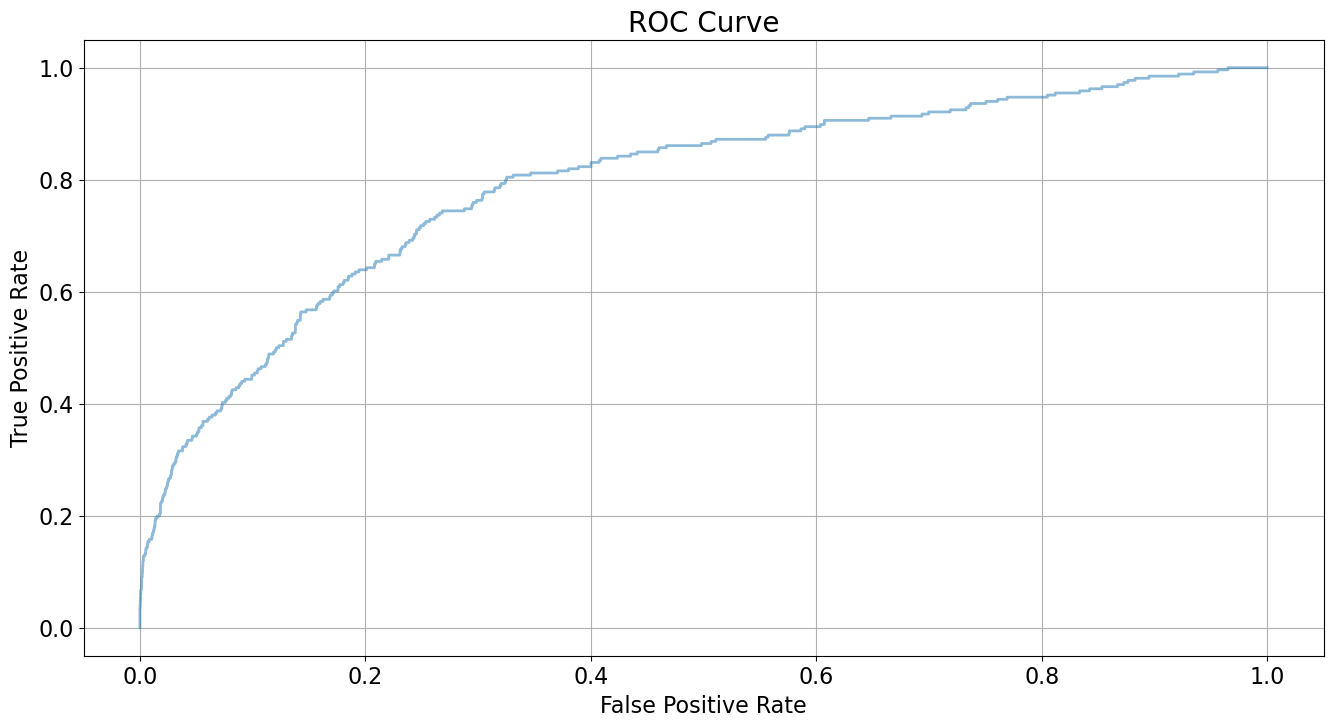

Площадь под кривой:  0.7919864350366361
f1:  0.20947630922693267


In [213]:
model_cb.set_probability_threshold(0.19)
catboost_pool = Pool(features_test, target_test, cat_features=['store'])
(fpr, tpr, thresholds) = get_roc_curve(model_cb, catboost_pool, plot=True)

probabilities_cb = model_cb.predict_proba(features_test)
print('Площадь под кривой: ', roc_auc_score(target_test, probabilities_cb[:,1]))

predictions = model_cb.predict(features_test)
print('f1: ', f1_score(target_test, predictions))

In [248]:
get_confusion_matrix(model_cb, Pool(features_test, target_test, cat_features=['store']))

array([[8779.,   13.],
       [ 247.,   19.]])

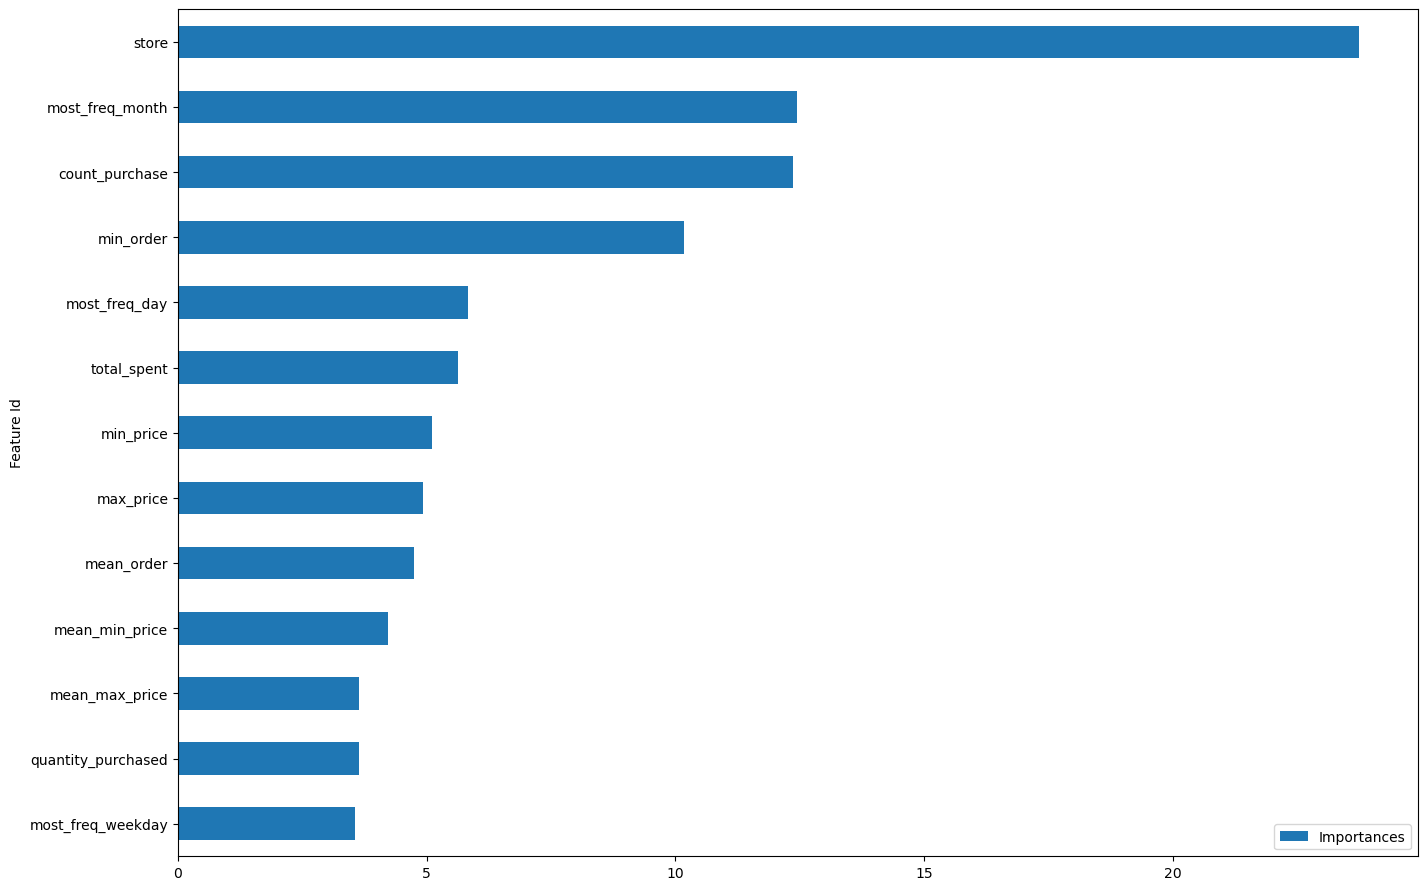

In [251]:
model_cb.get_feature_importance(prettified=True).sort_values(by = 'Importances', ascending = True).plot(kind = 'barh',use_index = True, figsize = (16,11), x = 'Feature Id')
plt.show()

#### Линейная модель

In [301]:
features_lr = features
target_lr = target

- Сделаем OneHoteEncoder.

In [312]:
for x in features_lr.index:
    if features_lr.loc[x, 'store'] == 1:
        features_lr.loc[x, 'store_1'] = 1
        features_lr.loc[x, 'store_2'] = 0
        features_lr.loc[x, 'store_3'] = 0
    if features_lr.loc[x, 'store'] == 2:
        features_lr.loc[x, 'store_1'] = 0
        features_lr.loc[x, 'store_2'] = 1
        features_lr.loc[x, 'store_3'] = 0
    if features_lr.loc[x, 'store'] == 3:
        features_lr.loc[x, 'store_1'] = 0
        features_lr.loc[x, 'store_2'] = 0
        features_lr.loc[x, 'store_3'] = 1
features_lr = features_lr.drop(['store'], axis=1)

- Сделаем масштабирование данных.

In [322]:
numeric = list(features_lr.columns)
numeric = numeric[:-3]

In [325]:
numeric = list(features_lr.columns)
numeric = numeric[:-3]
scaler = StandardScaler()
scaler.fit(features_lr[numeric])
features_lr[numeric] = scaler.transform(features_lr[numeric])

display(features_lr.head())

,quantity_purchased,count_purchase,total_spent,min_order,min_price,mean_min_price,max_price,mean_max_price,mean_order,most_freq_month,most_freq_day,most_freq_weekday,store_1,store_2,store_3
0,0.471670,-0.243380,1.223702,2.491428,0.359355,0.313424,0.779114,0.893915,0.497758,-1.661322,-1.336826,-0.577237,1,0,0
1,2.335414,1.860386,3.066577,-0.113071,-0.675491,-0.205758,0.393497,0.101592,0.006786,-1.065083,0.219424,-0.577237,1,0,0
2,0.626982,0.808503,-0.391758,-0.663561,-0.632719,-0.639330,-0.811554,-0.811672,-0.772536,1.319877,-0.139710,-1.140957,1,0,0
3,-0.304890,-0.243380,-0.350796,-0.427665,-0.264404,-0.307937,-0.570544,-0.553249,-0.454375,-0.766963,1.536251,0.550203,1,0,0
4,0.005734,-0.243380,-0.157658,-0.069590,-0.264404,-0.307937,-0.468838,-0.444195,-0.392380,0.127397,-1.336826,-1.140957,1,0,0


In [326]:

features_train, features_test, target_train, target_test = train_test_split(
    features_lr, target_lr, test_size=0.2, random_state=rnd, stratify = target_lr, shuffle = True)

In [330]:
model_lr = LogisticRegression()
model_lr.fit(features_train, target_train)


LogisticRegression()

In [332]:
scores = cross_val_score(model_lr, features_train, target_train, cv=5, scoring='f1')
print(scores)
print('Средняя оценка качества модели:', scores.mean())

/home/chvan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.09565217 0.09482759 0.10572687 0.14049587 0.11206897]
Средняя оценка качества модели: 0.10975429313049449


In [333]:
probabilities_lr = model_lr.predict_proba(features_test)
print('Площадь под кривой: ', roc_auc_score(target_test, probabilities_lr[:,1]))

predictions = model_lr.predict(features_test)
print('f1: ', f1_score(target_test, predictions))

Площадь под кривой:  0.7785813914905553
f1:  0.07719298245614035


Несмотря на близкие значения метрики roc-auc, мера f1 в 3 раза ниже. 

### Выводы

- Набор данных был пересобран, покупки в одну дату объеденены в единую покупку.
- У магазинов различная сезонность и различная лояльность аудитории. Самым важным фактором предсказания являлся именно индикатор площадки.
- Для того, чтобы покупки в разных магазинах были похожи друг на друга, все цены (общая стоимость, минимальная, средняя и т.п.) нормировались на цену максимального товара на площадке.
- У площадок различная лояльность - в магазине одежды чаще покупают больше одной вещи, а на маркетплейс чаще возвращаются.
- Крайне низкое количество целевого признака. За повторными покупками возвращаются всего 2-6% покупателей.

С предсказанием целевого признака лучше всего справилась модель CatBoost:
    CatBoostClassifier(l2_leaf_reg = 7, max_depth = 5, n_estimators = 1000, random_seed = 54321)

Порог предсказания положительного класса : 0.19

AUC-ROC:  0.792
f1 мера:  0.21


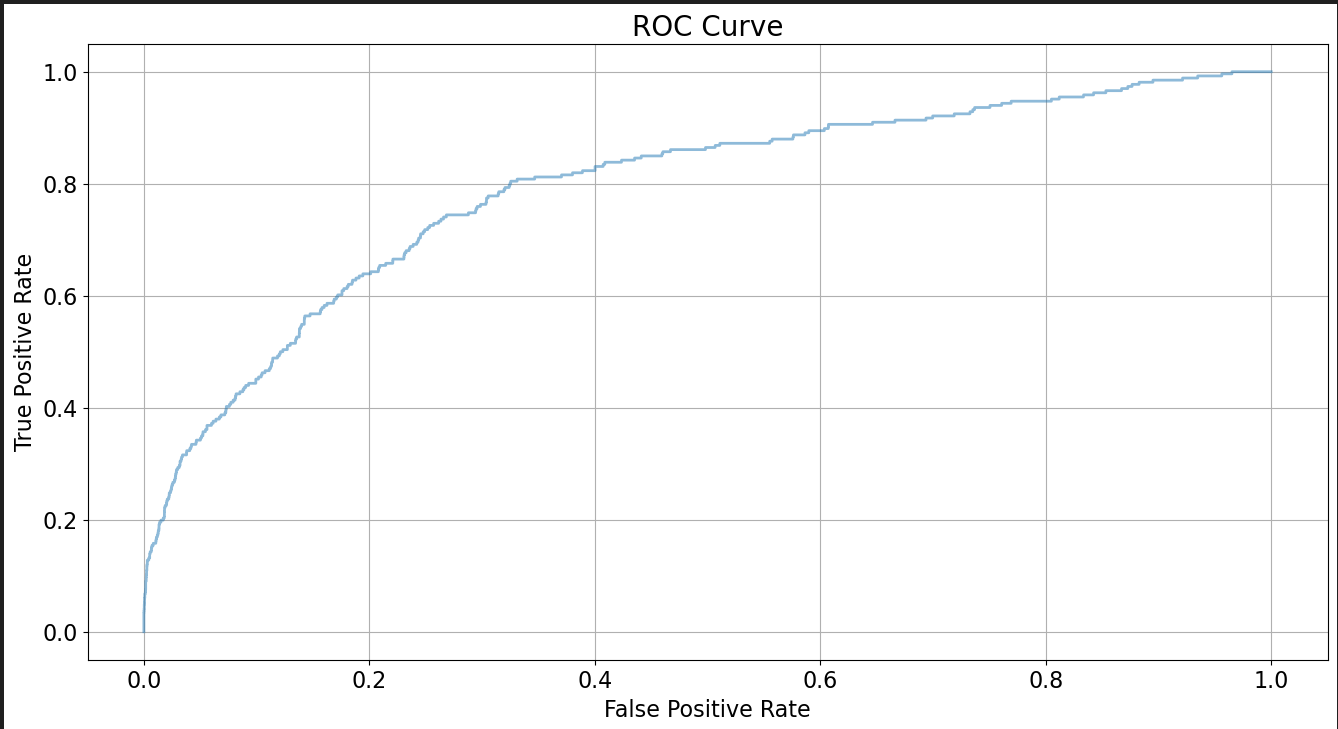

Самыми важными признаками являются:
 - В каком магазине совершалась покупка;
 - В каком месяце чаще всего совершалась покупка;
 - Сколько уже было совершено покупок ранее;
 - Какая минимальная сумма заказа у какого-либо из купленных товаров;
 - В какой день месяца чаще всего совершалась покупка.

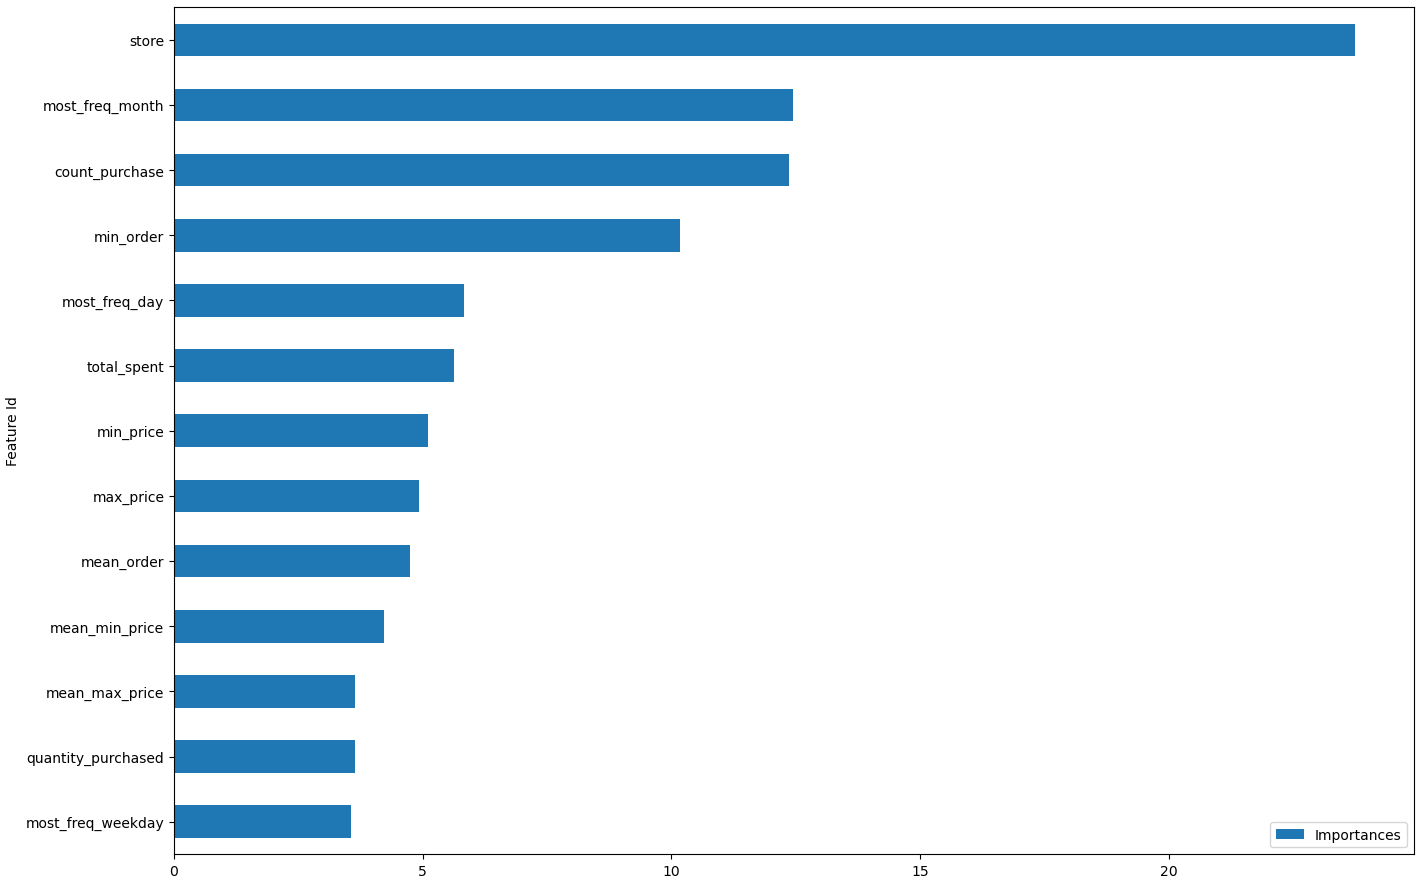

То, что не получилось:
 - Одной из главных проблем является крайне низкое колчеиство целевого признака. Необходимо построить пайплайн, который будет собирать ежемесячно статистику по набору целевого признака;
 - Необходимо в метрику добавить "вес" покупки: чем выше сумма совершенной покупки, тем более весомым должно стать предсказание этой покупки. К сожалению не получилось адекватно совменстить классификатор и регрессор, для увеличение веса целевых признаков;
 - При накоплении большого количества информации, необходимо выстраивать модель именно по тем клиентам, которые в течении непродолжительного количества времени вернулись за повторной покупкой. Если поставить отсечку не в 30, а в 90 дней, то можно попытаться найти разницу между теми, кто в итоге вернулся в магазин и найти что сильнее влияет на повторность заказа: сумма покупки или количество товара и исходя из этого строить маркетинговую стратегию: наполнять плоащдки более дешевыми товарами для увеличения количества или добавлять дорогие товары для увеличения среднего чека.